In [1]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
df_Dos = pd.read_csv(r'dos1.csv')
df_Malfunc = pd.read_csv(r'malfunction1.csv')
df_Norm = pd.read_csv(r'normal1.csv')

In [2]:

print('Loaded shapes:')
print('Dos:', df_Dos.shape)
print('Malfunction:', df_Malfunc.shape)
print('Normal:', df_Norm.shape)

print('Number of columns: dos={}, mal={}, normal={}'.format(len(df_Dos.columns), len(df_Malfunc.columns), len(df_Norm.columns)))
print('Do columns match exactly (dos vs mal):', all(df_Malfunc.columns == df_Dos.columns))
print('Do columns match exactly (dos vs normal):', all(df_Norm.columns == df_Dos.columns))

print('df_Dos.head(2)Dos columns sample and dtypes:', df_Dos.dtypes.head(10))

Loaded shapes:
Dos: (17204, 79)
Malfunction: (9040, 79)
Normal: (11599, 79)
Number of columns: dos=79, mal=79, normal=79
Do columns match exactly (dos vs mal): True
Do columns match exactly (dos vs normal): True
df_Dos.head(2)Dos columns sample and dtypes: S.No                                       int64
setpoint_raw-global_Time                 float64
setpoint_raw-global_header.seq             int64
setpoint_raw-global_header.stamp.secs      int64
setpoint_raw-global_latitude             float64
setpoint_raw-global_longitude            float64
setpoint_raw-global_altitude             float64
battery_Time                             float64
battery_header.seq                       float64
battery_header.stamp.secs                float64
dtype: object


In [3]:
df_Norm['label'] = 'Norm'
df_Dos['label'] = 'Dos'
df_Malfunc['label'] = 'Malfuc'


In [4]:
colsToBackfill=df_Norm.columns[7:]
df_Norm[colsToBackfill] = df_Norm[colsToBackfill].replace(r"^\s*$", np.nan, regex=True)
df_Norm[colsToBackfill] = df_Norm[colsToBackfill].ffill()
df_Malfunc[colsToBackfill] = df_Malfunc[colsToBackfill].replace(r"^\s*$", np.nan, regex=True)
df_Malfunc[colsToBackfill] = df_Malfunc[colsToBackfill].ffill()
df_Dos[colsToBackfill] = df_Dos[colsToBackfill].replace(r"^\s*$", np.nan, regex=True)
df_Dos[colsToBackfill] = df_Dos[colsToBackfill].ffill()
df=pd.concat([df_Dos,df_Malfunc,df_Norm],ignore_index=True)


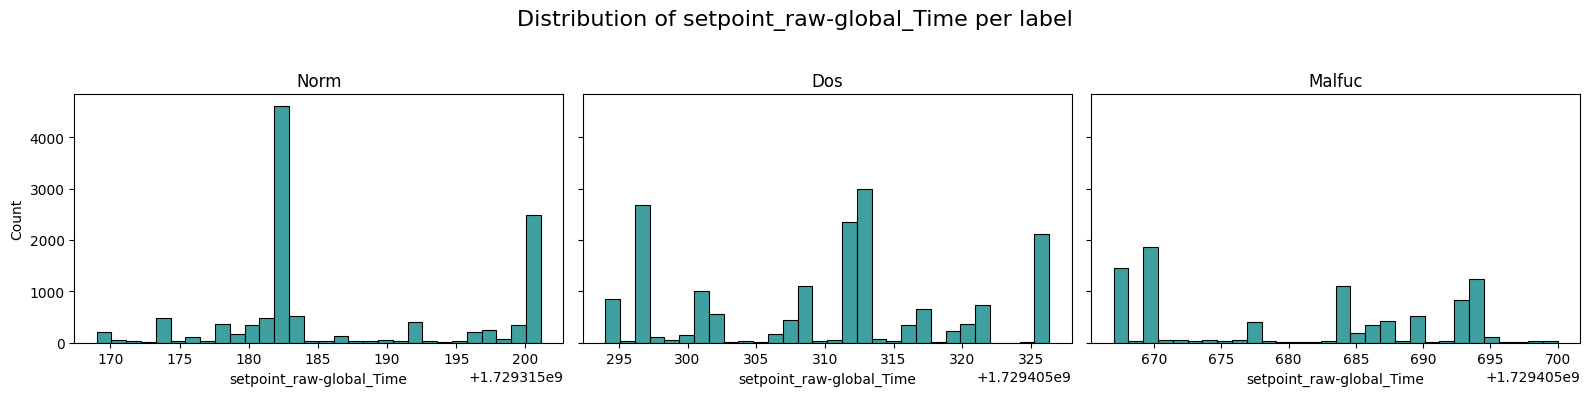

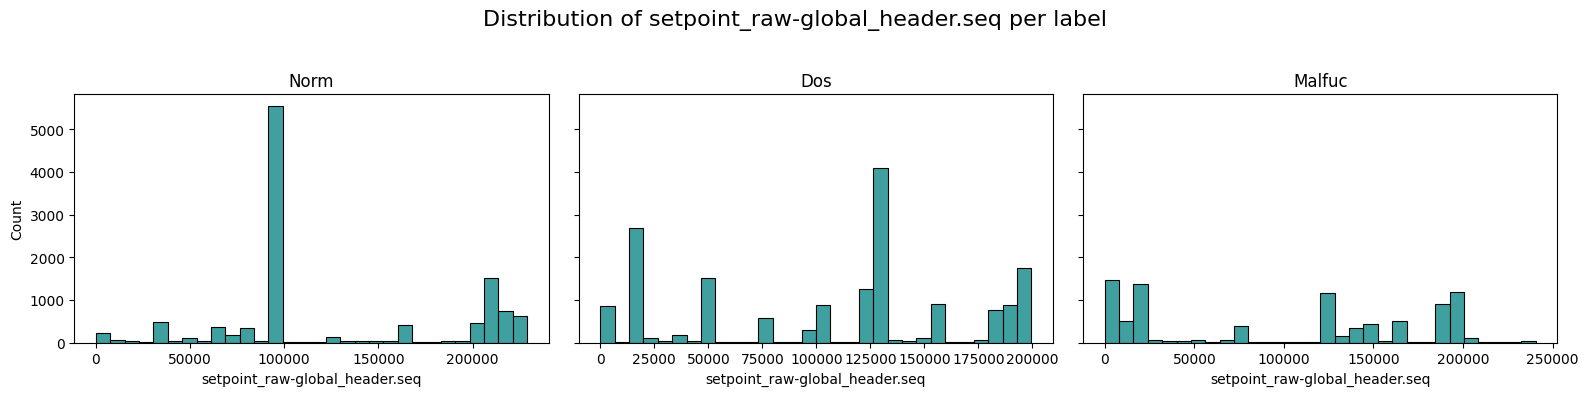

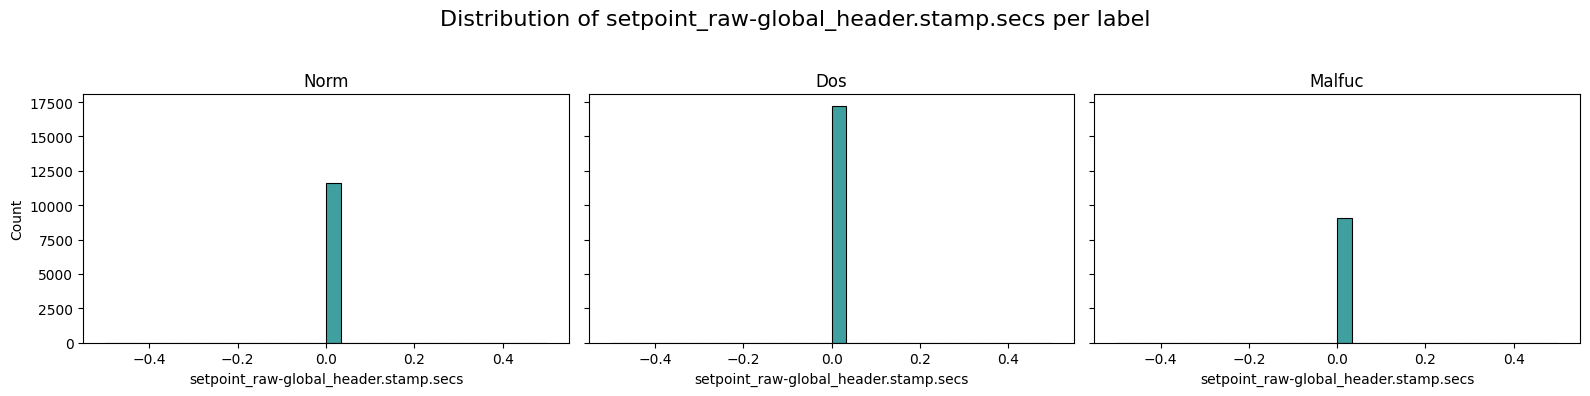

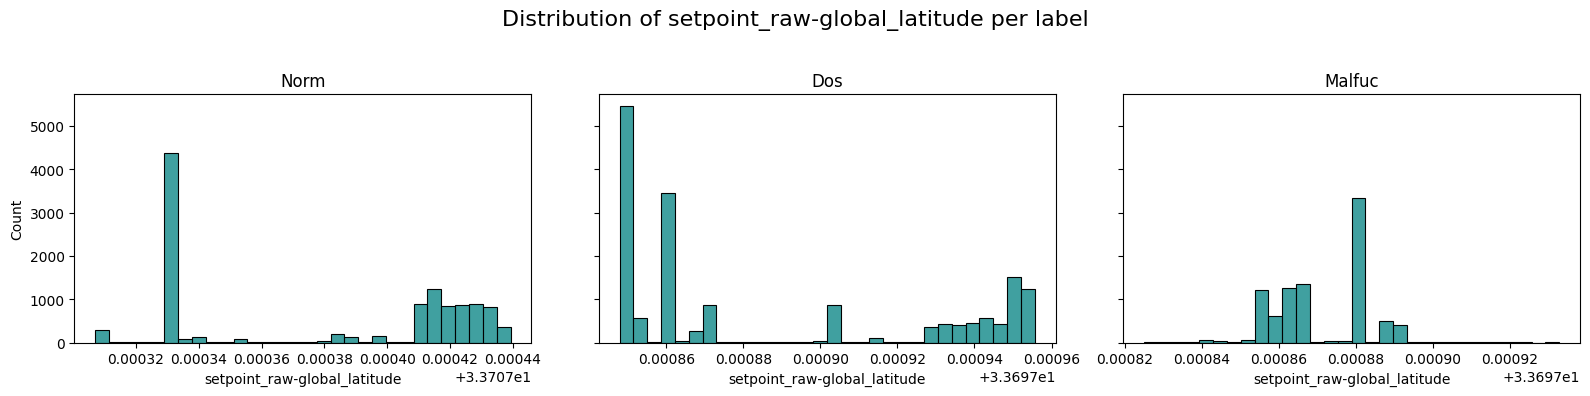

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = df.select_dtypes(include='number').columns[0:5]
labels = ['Norm', 'Dos', 'Malfuc']

for col in num_cols:
    if col == 'S.No':
        continue
    fig, axes = plt.subplots(1, len(labels), figsize=(16, 4), sharey=True)
    fig.suptitle(f'Distribution of {col} per label', fontsize=16)
    for i, label in enumerate(labels):
        df_label = df[df['label'] == label]
        sns.histplot(df_label[col], bins=30, color='teal', ax=axes[i], kde=False)
        axes[i].set_title(label)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [93]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

plots = [
    ('CPU_Percent', 'CPU_Percent', 'CPU Usage Scatter', px.colors.sequential.Viridis),
    ('Used_RAM_MB', 'Used_RAM_MB', 'RAM Usage Scatter', px.colors.sequential.Plasma),
    ('setpoint_raw-target_global_longitude', 'global_position-global_longitude', 'Longitude Comparison', px.colors.sequential.Cividis),
    ('setpoint_raw-target_global_latitude', 'global_position-global_latitude', 'Latitude Comparison', px.colors.sequential.Magma)
]



In [94]:

for x_col, y_col, title, colors in plots:
    fig = px.scatter(
        df,
        x=x_col,
        y=y_col,
        color='label',
        title=title,
        color_discrete_sequence=colors,
      
        width=500,
        height=400
    )
    fig.update_traces(marker=dict(size=6, opacity=0.8))
    fig.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "notebook_connected"

latLongCols = [c for c in df.columns if 'latitude' in c or 'longitude' in c]
labels = df['label'].unique()

fig = make_subplots(rows=len(latLongCols), cols=1, subplot_titles=latLongCols, vertical_spacing=0.1)

for i, col in enumerate(latLongCols, start=1):
    for label in labels:
        df_label = df[df['label'] == label]
        fig.add_trace(
            go.Scatter(
                x=df_label[col],
                y=df_label[col],
                mode='markers',
                name=label if i == 1 else None,
                marker=dict(size=6, opacity=0.7),
                legendgroup=label
            ),
            row=i, col=1
        )

fig.update_layout(height=300*len(latLongCols), width=600, template='plotly_dark', showlegend=True)
fig.show()



In [78]:
import plotly.express as px

# Extract columns
timeColumns = [c for c in df.columns if 'Time' in c]
sequenceColumns = [c for c in df.columns if '.seq' in c]

for seq_col in sequenceColumns:
    
    prefix = seq_col.split('.')[0].split("_hea")[0]   
    print(prefix)
    time_col = [t for t in timeColumns if prefix in t]
    print(time_col)

    if not time_col:
        continue  # no matching time column found

    time_col = time_col[0]  # use the first match

    fig = px.scatter(
        df,
        x=time_col,
        y=seq_col,
        color="label",
        title=f"{seq_col} vs {time_col}"
        ,       template="plotly_dark",
    )
    fig.show()


Numeric columns count: 51
Plotting columns found: ['battery_voltage', 'battery_current', 'battery_percentage', 'vfr_hud_airspeed', 'vfr_hud_groundspeed', 'RSSI_Quality', 'CPU_Percent', 'Used_RAM_MB']


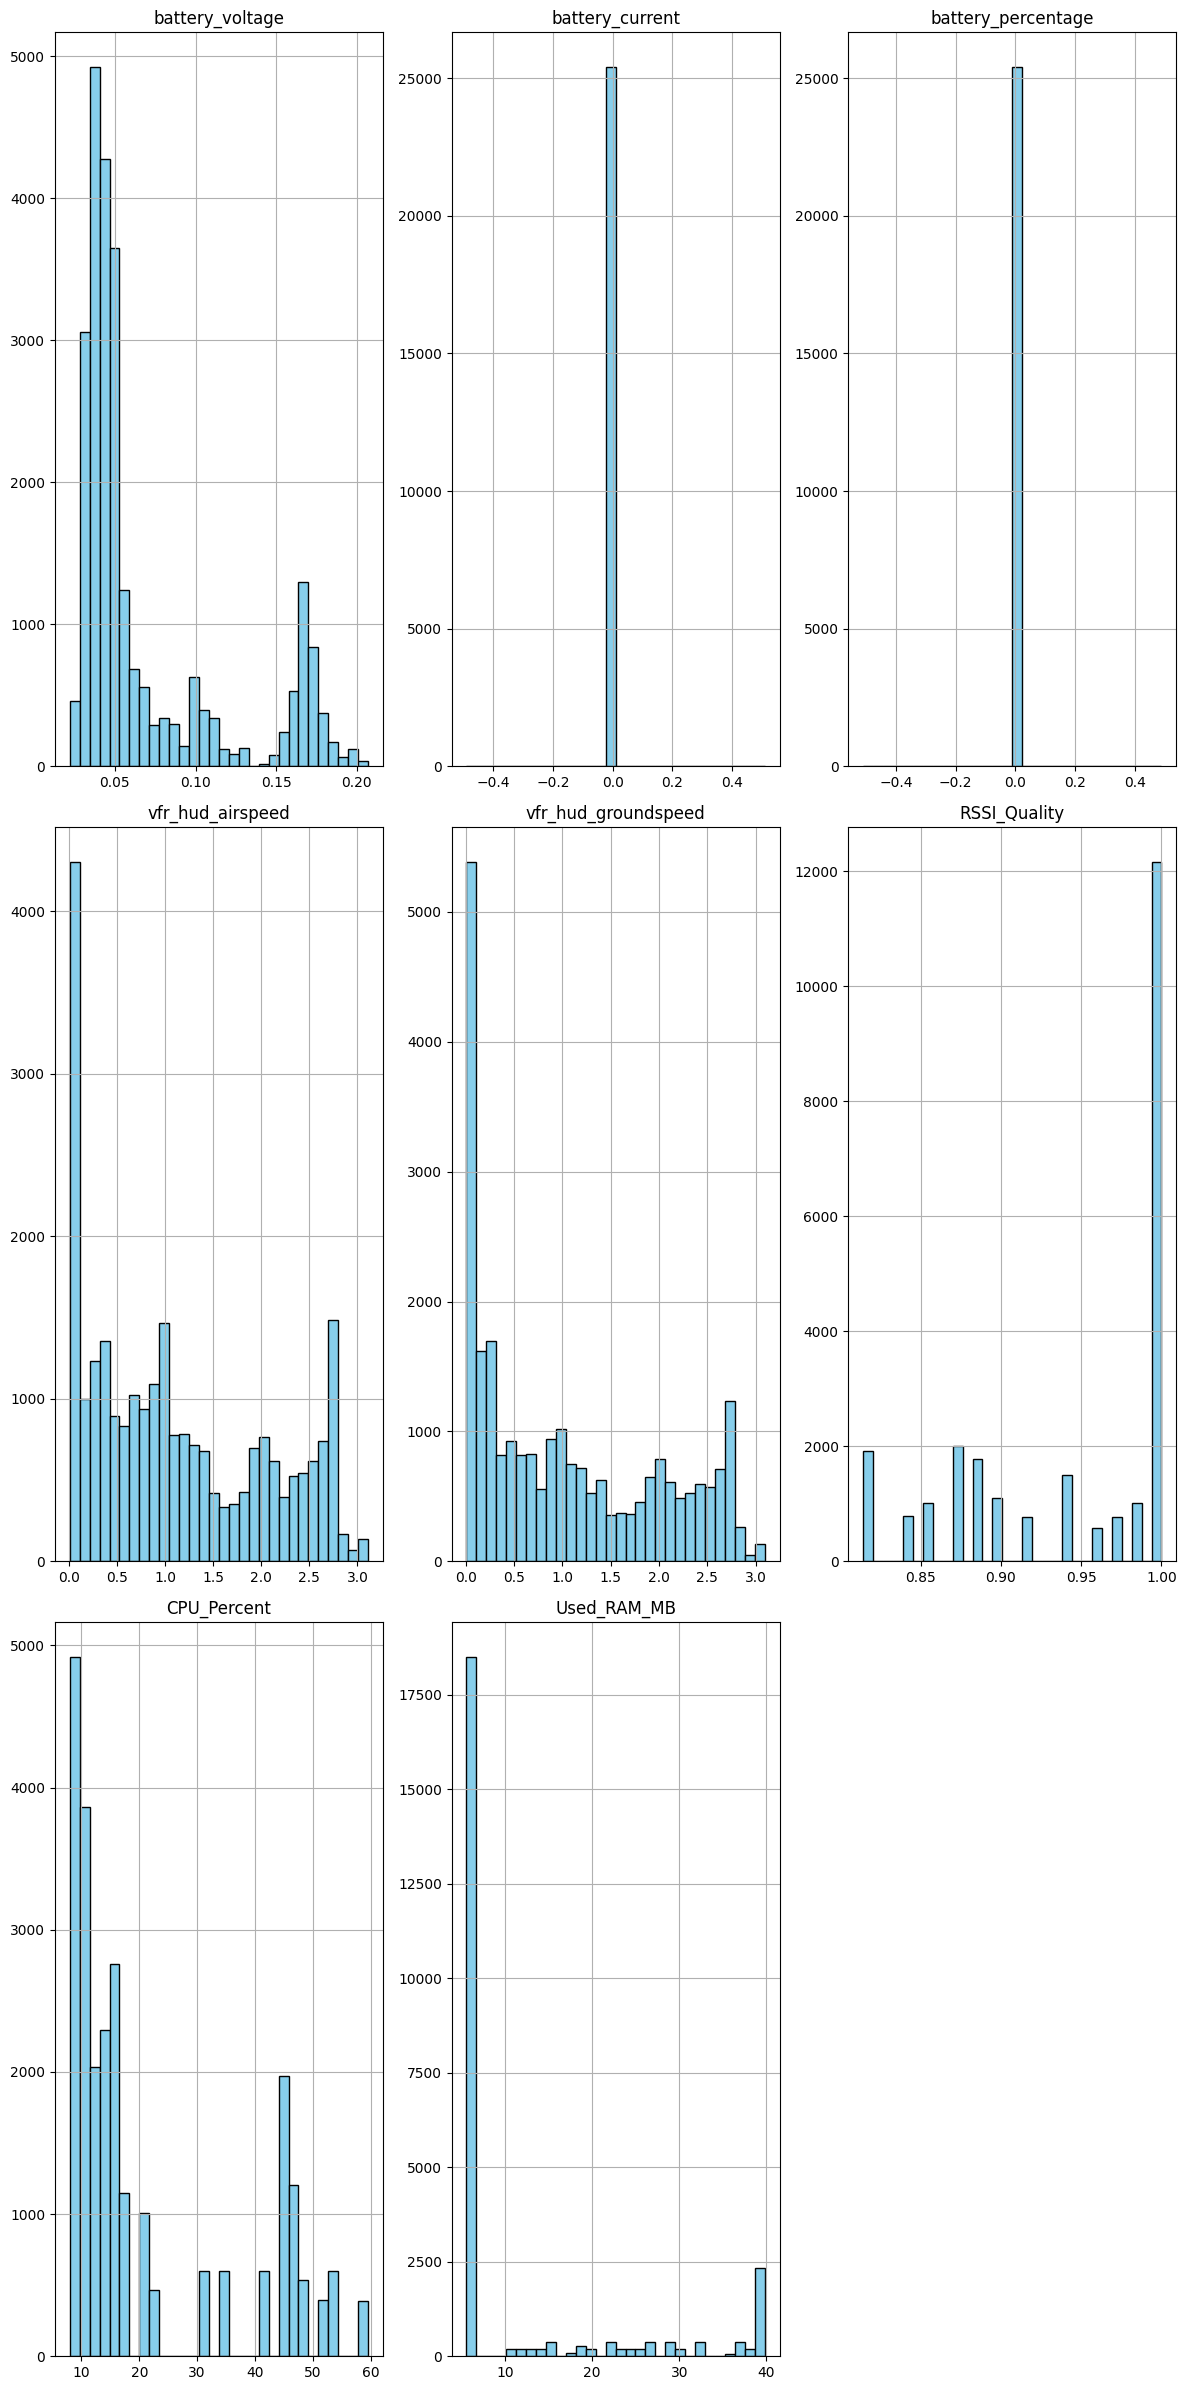


Sample rows:


setpoint_raw-global_latitude  setpoint_raw-global_longitude  \
15259                     33.697853                      73.016534   
6912                      33.697873                      73.016579   
10069                     33.697951                      73.016561   
7671                      33.697936                      73.016573   
9448                      33.697949                      73.016564   

       setpoint_raw-global_altitude  battery_voltage  battery_current  \
15259                         4.452            0.040             0.01   
6912                          5.368            0.042             0.01   
10069                         5.819            0.026             0.01   
7671                          5.800            0.039             0.01   
9448                          5.815            0.033             0.01   

       battery_temperature  battery_percentage  \
15259                  0.0               -0.01   
6912                   0.0               -0.01   
10069                  0.0               -0.01   
7671                   0.0               -0.01   
9448                   0.0               -0.01   

       global_position-local_pose.pose.position.x  \
15259                                    1.298053   
6912                                    -0.324513   
10069                                    1.121887   
7671                                     5.627985   
9448                                     4.172309   

       global_position-local_pose.pose.position.y  \
15259                                    2.163056   
6912                                     1.364388   
10069                                   11.480832   
7671                                     2.640038   
9448                                     9.461981   

       global_position-local_pose.pose.position.z  ...  state_connected  \
15259                                       6.400  ...              1.0   
6912                                        3.468  ...              1.0   
10069                                       5.833  ...              1.0   
7671                                        5.135  ...              1.0   
9448                                        5.669  ...              1.0   

       state_armed  state_guided  state_manual_input  state_system_status  \
15259          1.0           1.0                 1.0                  5.0   
6912           1.0           1.0                 1.0                  5.0   
10069          1.0           1.0                 1.0                  5.0   
7671           1.0           1.0                 1.0                  5.0   
9448           1.0           1.0                 1.0                  5.0   

       RSSI_Quality  RSSI_Signal  CPU_Percent  Used_RAM_MB  label  
15259      0.942857        -44.0         52.8         29.4      M  
6912       1.000000        -38.0         10.4          5.6      D  
10069      0.814286        -53.0         10.6          5.6      D  
7671       1.000000        -40.0         14.4          5.6      D  
9448       0.814286        -53.0          8.6          5.6      D  

[5 rows x 52 columns]

In [79]:
import matplotlib.pyplot as plt
import numpy as np

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric columns count:', len(numeric_cols))

candidates = ['battery_voltage','battery_current','battery_percentage',
              'vfr_hud_airspeed','vfr_hud_groundspeed','RSSI_Quality',
              'CPU_Percent','Used_RAM_MB']
plot_cols = [c for c in candidates if c in df.columns]
print('Plotting columns found:', plot_cols)

if len(plot_cols) > 0:
    df[candidates].hist(bins=30, figsize=(12, 3*len(plot_cols)), color='skyblue', edgecolor='black')
    plt.tight_layout()
    plt.show()

print('\nSample rows:')
display(df.sample(min(5, len(df)), random_state=42))


In [74]:
def remove_outliers_by_label_loose(df, label_col, iqr_multiplier=3.0):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != label_col]
    
    cleaned_df = pd.DataFrame()
    
    for lbl in df[label_col].unique():
        subset = df[df[label_col] == lbl].copy()
        for col in numeric_cols:
            Q1 = subset[col].quantile(0.25)
            Q3 = subset[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - iqr_multiplier * IQR
            upper = Q3 + iqr_multiplier * IQR
            subset = subset[(subset[col] >= lower) & (subset[col] <= upper)]
        cleaned_df = pd.concat([cleaned_df, subset])
    
    return cleaned_df.reset_index(drop=True)

df_clean = remove_outliers_by_label_loose(df, 'label',20)
print('Original rows:', len(df), 'Cleaned rows:', len(df_clean))
df=df_clean


Original rows: 37843 Cleaned rows: 25393


In [75]:
threshold = 0.7
df = df.dropna(axis=1, thresh=int((1 - threshold) * len(df)))
drop_cols = [c for c in df.columns if ("_Time" in c) or (".seq" in c) or  (".secs" in c) or ("S.No" in c)]

df.drop(columns=drop_cols, inplace=True)


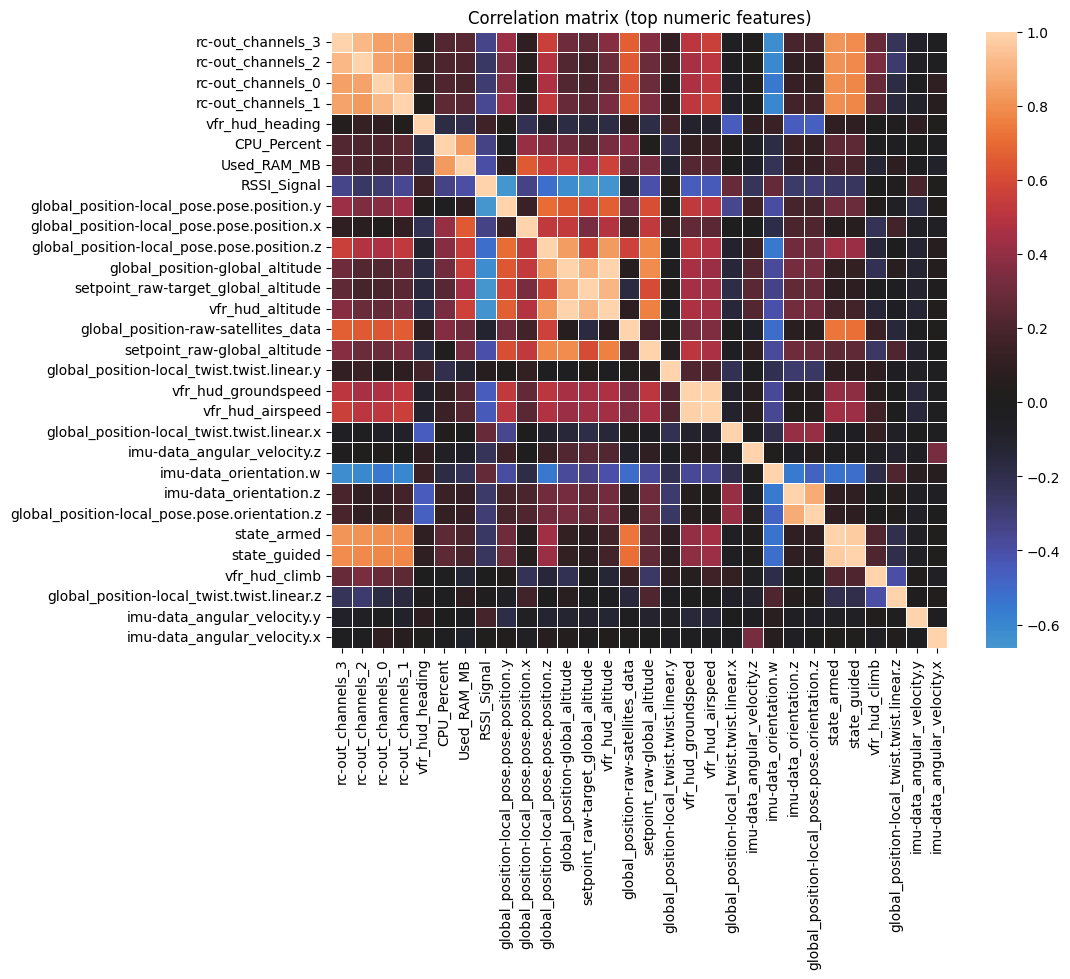

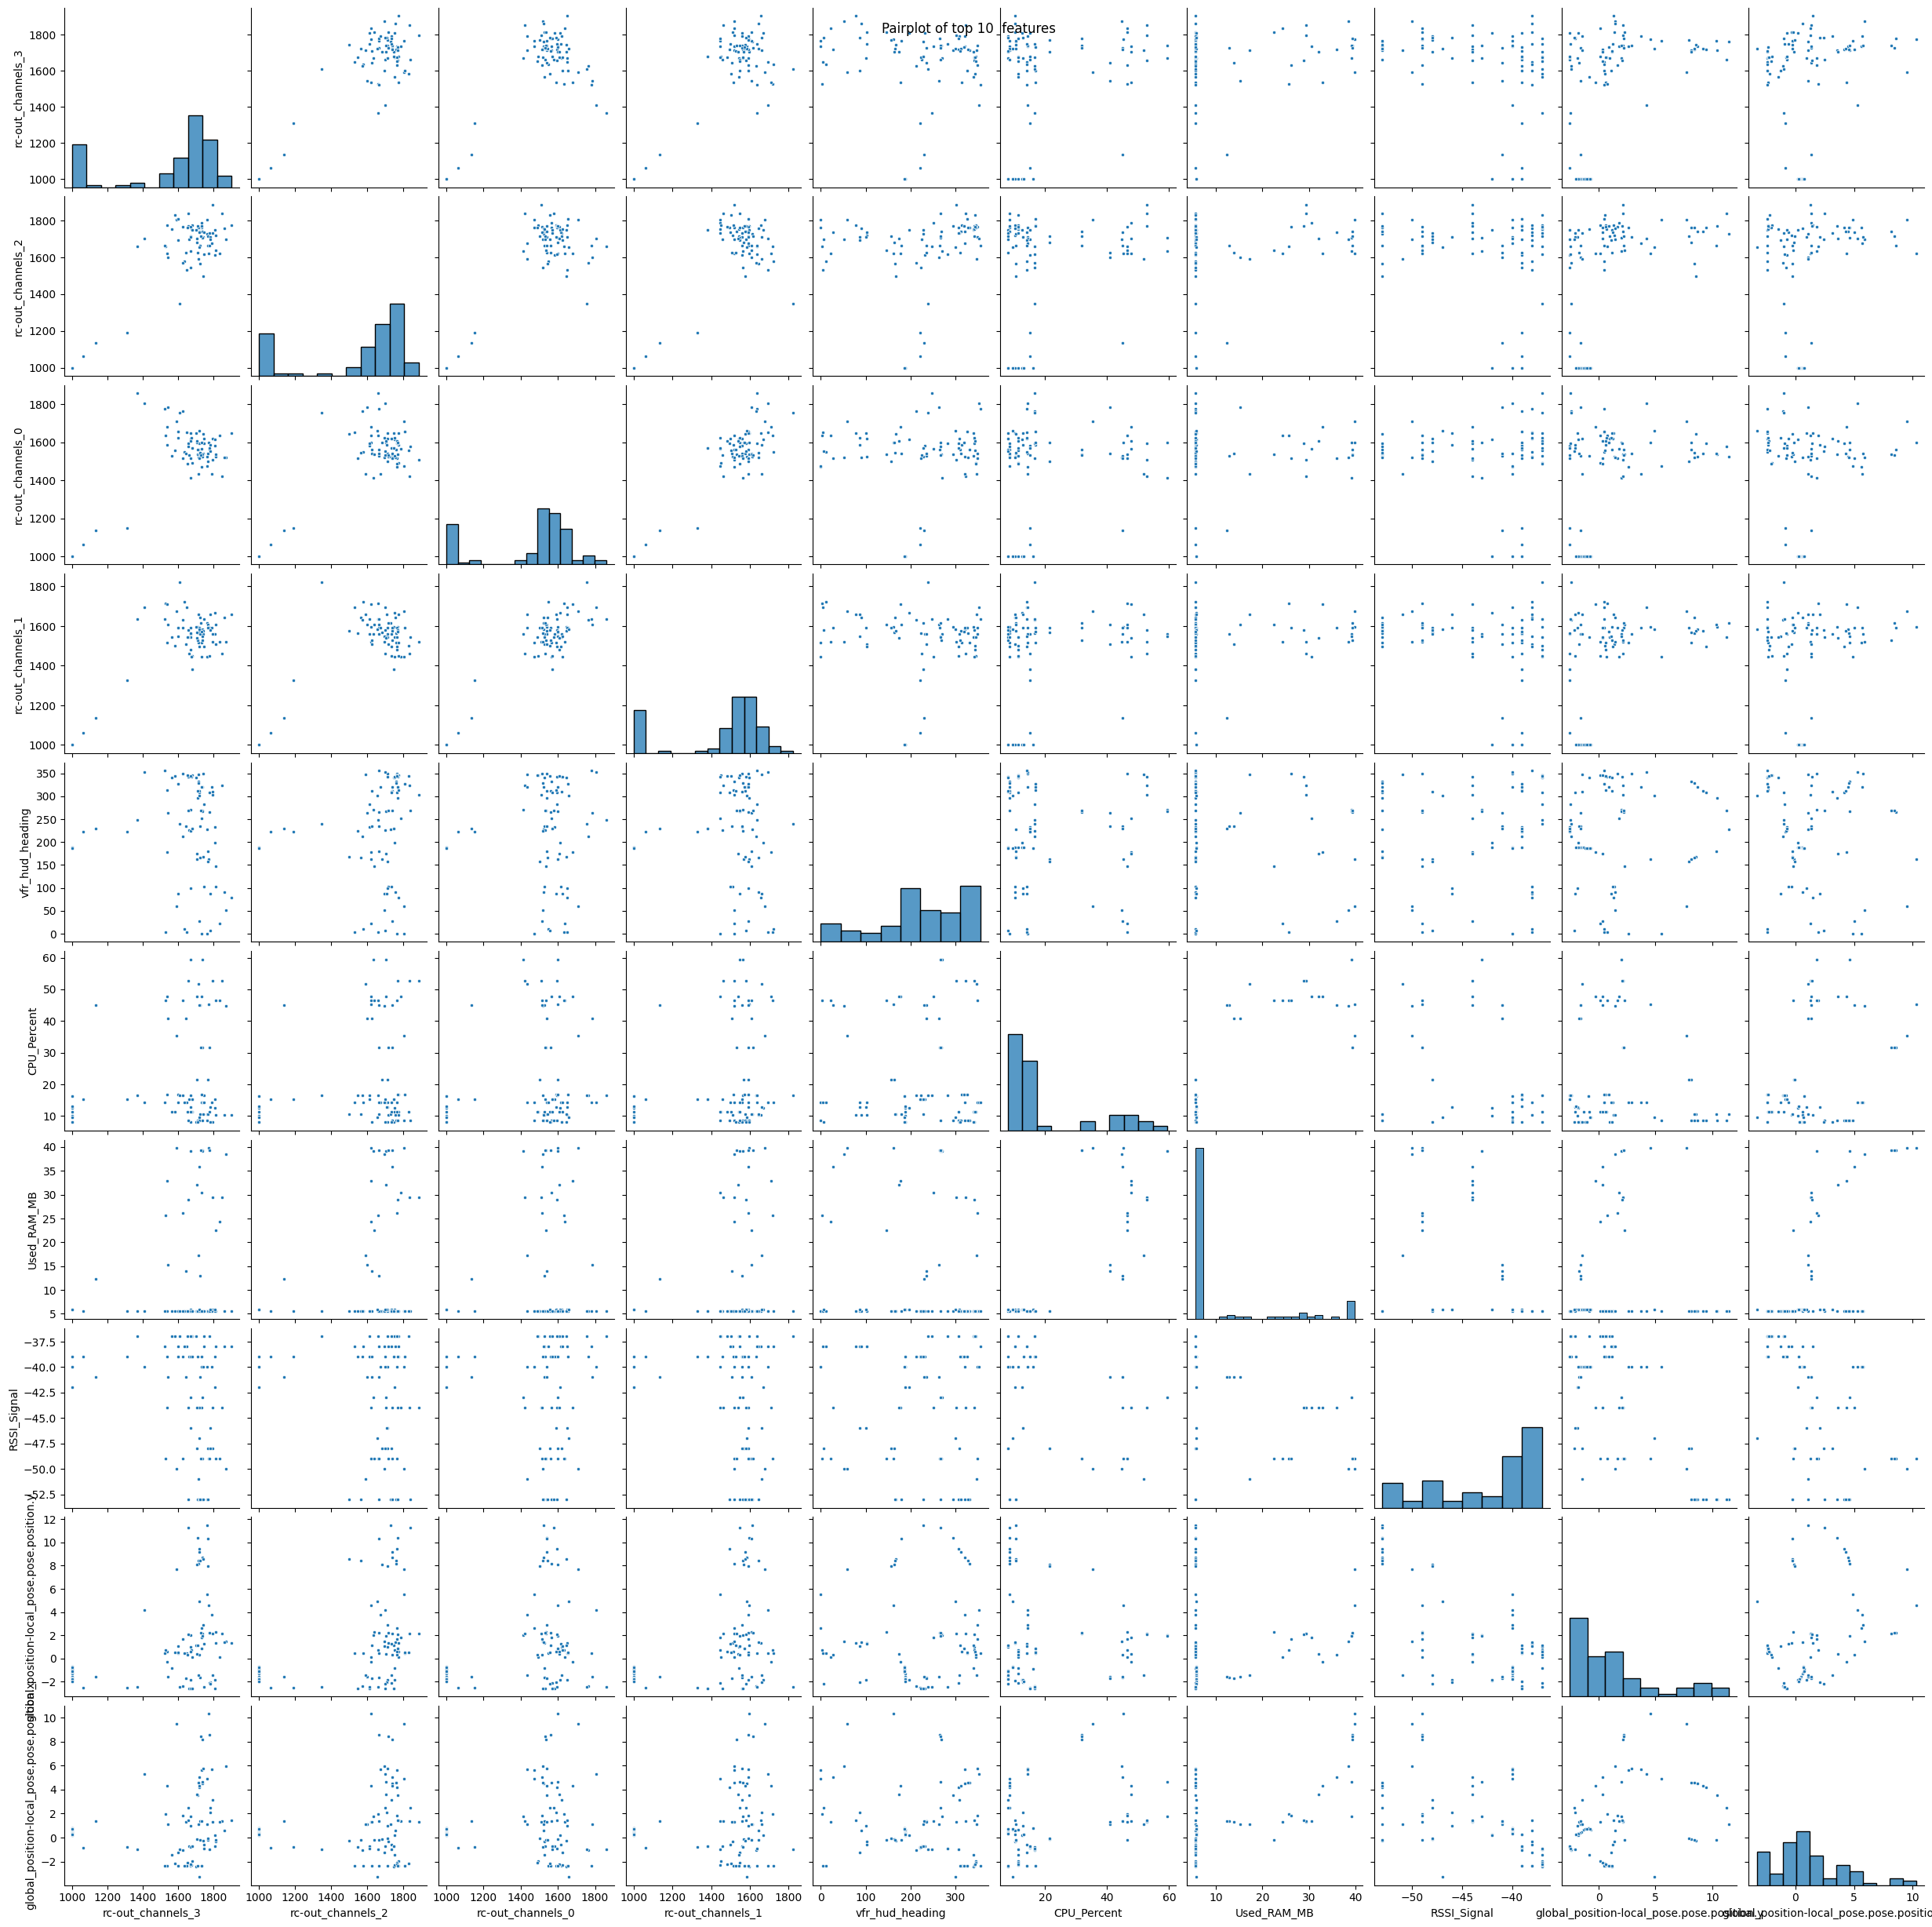

In [76]:

numeric = df.select_dtypes(include=[np.number]).copy()
if numeric.shape[1] == 0:
    print('No numeric features available for correlation matrix')
else:
   
    var = numeric.var().sort_values(ascending=False)
    top_feats = var.head(30).index.tolist() if len(var) > 30 else var.index.tolist()
    corr = numeric[top_feats].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, center=0, square=True, linewidths=.5)
    plt.title('Correlation matrix (top numeric features)')
    plt.show()
   
    if len(top_feats) >= 10:
        sample_df = numeric[top_feats[:10]].sample(min(100, len(numeric)), random_state=42)
        sns.pairplot(sample_df,markers='.',palette='bright')
        plt.suptitle('Pairplot of top 10  features')
        plt.show()

Potential time columns found: []
State columns candidates: ['state_connected', 'state_armed', 'state_guided', 'state_manual_input', 'state_system_status']

Value counts for state_connected
state_connected
1.0    25393
Name: count, dtype: int64

Value counts for state_armed
state_armed
1.0    22372
0.0     3021
Name: count, dtype: int64

Value counts for state_guided
state_guided
1.0    22531
0.0     2862
Name: count, dtype: int64

Value counts for state_manual_input
state_manual_input
1.0    25393
Name: count, dtype: int64

Value counts for state_system_status
state_system_status
5.0    25393
Name: count, dtype: int64


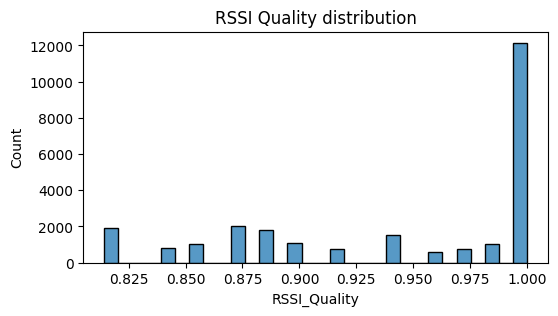


EDA complete. Next: feature engineering and preprocessing.


In [77]:

time_cols = [c for c in df.columns if 'Time' in c or 'time' in c.lower() or 'stamp' in c.lower()]
print('Potential time columns found:', time_cols)

if len(time_cols) > 0:
    tcol = time_cols[0]
    try:
        df['_ts_parsed'] = pd.to_datetime(df[tcol], unit='s', errors='coerce')
        print('Parsed datetime from', tcol, ' — nulls:', df['_ts_parsed'].isna().sum())
        # plot CPU over time if available
        if 'CPU_Percent' in df.columns:
            sample = df[[ '_ts_parsed', 'CPU_Percent']].dropna().sort_values('_ts_parsed').head(5000)
            plt.figure(figsize=(12,3))
            plt.plot(sample['_ts_parsed'], sample['CPU_Percent'], marker='.', linestyle='-', markersize=2)
            plt.title('CPU Percent over time (sample)')
            plt.xlabel('time')
            plt.ylabel('CPU_Percent')
            plt.show()
    except Exception as e:
        print('Could not parse time column:', e)
# State columns distribution (boolean-like)
state_cols = [c for c in df.columns if c.lower().startswith('state') or c.lower().startswith('state_') or c.lower().startswith('state-') or c.lower().startswith('state ')]
print('State columns candidates:', state_cols)
for c in state_cols:
    print('\nValue counts for', c)
    print(df[c].value_counts(dropna=False).head(20))
# If RSSI exists, show distribution
if 'RSSI_Quality' in df.columns:
    plt.figure(figsize=(6,3))
    sns.histplot(df['RSSI_Quality'].dropna(), bins=30)
    plt.title('RSSI Quality distribution')
    plt.show()
print('\nEDA complete. Next: feature engineering and preprocessing.')

Counts by label:
label
DoS_Attack     11974
Malfunction     6908
Normal          6511
Name: count, dtype: int64
Numeric features count: 51


label                                          DoS_Attack  Malfunction  \
setpoint_raw-global_latitude                    33.697890    33.697874   
setpoint_raw-global_longitude                   73.016533    73.016553   
setpoint_raw-global_altitude                     3.993921     4.044844   
battery_voltage                                  0.043031     0.051639   
battery_current                                  0.010000     0.010000   
battery_temperature                              0.000000     0.000000   
battery_percentage                              -0.010000    -0.010000   
global_position-local_pose.pose.position.x       0.103651     3.891534   
global_position-local_pose.pose.position.y       2.593516     1.770428   
global_position-local_pose.pose.position.z       3.381037     4.503789   
global_position-local_pose.pose.orientation.x   -0.025075    -0.024545   
global_position-local_pose.pose.orientation.y    0.004781     0.002393   
global_position-local_pose.pose.orientation.z   -0.655417    -0.586443   
global_position-local_twist.twist.linear.x      -0.070149    -0.031325   
global_position-local_twist.twist.linear.y       0.323349    -0.024952   
global_position-local_twist.twist.linear.z      -0.177905    -0.168098   
imu-data_orientation.x                          -0.024699    -0.022723   
imu-data_orientation.y                           0.005478     0.001035   
imu-data_orientation.z                          -0.650066    -0.576828   
imu-data_orientation.w                          -0.331562    -0.396074   

label                                             Normal  
setpoint_raw-global_latitude                   33.707407  
setpoint_raw-global_longitude                  73.019756  
setpoint_raw-global_altitude                    3.315906  
battery_voltage                                 0.130533  
battery_current                                 0.010000  
battery_temperature                             0.000000  
battery_percentage                             -0.010000  
global_position-local_pose.pose.position.x     -0.265512  
global_position-local_pose.pose.position.y      0.151185  
global_position-local_pose.pose.position.z      0.777133  
global_position-local_pose.pose.orientation.x   0.014458  
global_position-local_pose.pose.orientation.y   0.018952  
global_position-local_pose.pose.orientation.z  -0.692876  
global_position-local_twist.twist.linear.x     -0.154386  
global_position-local_twist.twist.linear.y      0.257232  
global_position-local_twist.twist.linear.z     -0.096684  
imu-data_orientation.x                          0.015179  
imu-data_orientation.y                          0.019011  
imu-data_orientation.z                         -0.694689  
imu-data_orientation.w                          0.219715

Top features by mean difference: ['rc-out_channels_3', 'rc-out_channels_2', 'rc-out_channels_1', 'rc-out_channels_0', 'vfr_hud_heading', 'CPU_Percent', 'Used_RAM_MB', 'RSSI_Signal', 'global_position-raw-satellites_data', 'global_position-local_pose.pose.position.x', 'global_position-local_pose.pose.position.z', 'global_position-local_pose.pose.position.y', 'setpoint_raw-target_global_altitude', 'vfr_hud_altitude', 'global_position-global_altitude', 'setpoint_raw-global_altitude', 'vfr_hud_airspeed', 'imu-data_orientation.w', 'vfr_hud_groundspeed', 'state_armed']


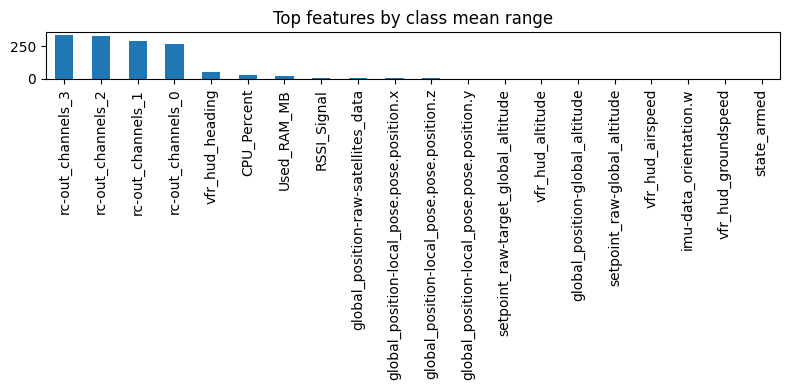

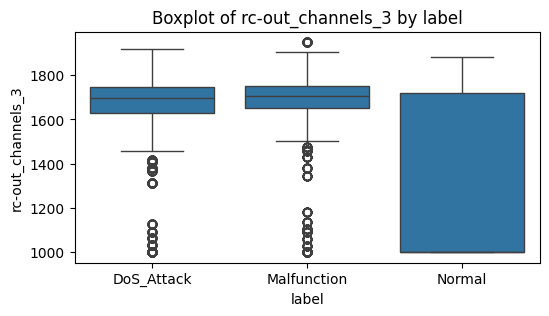

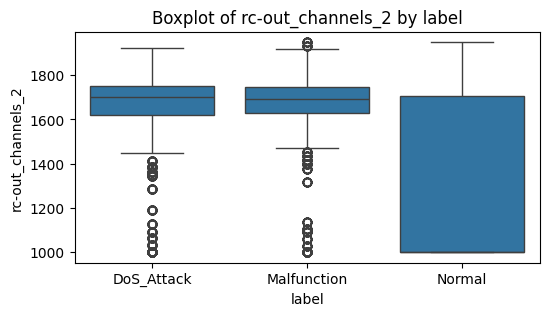

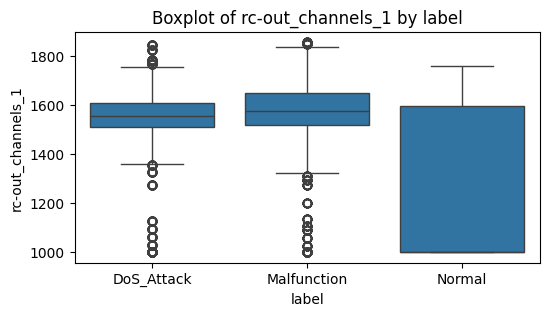

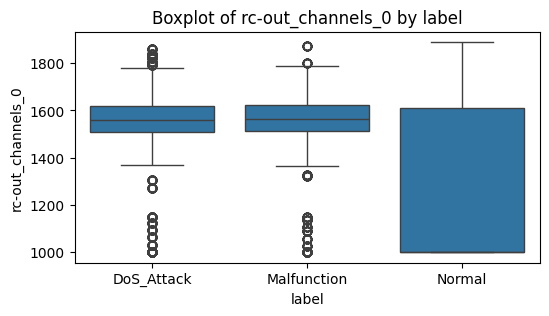

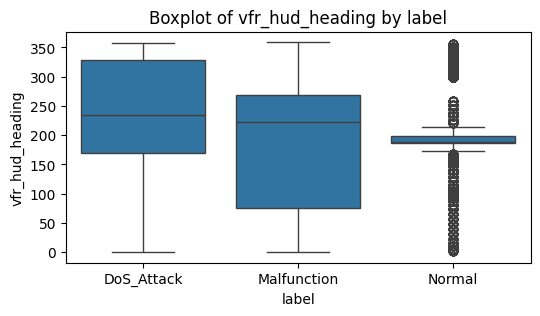

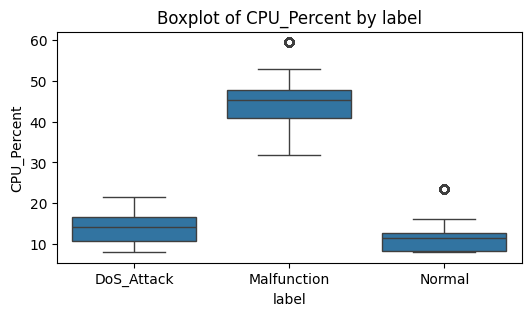

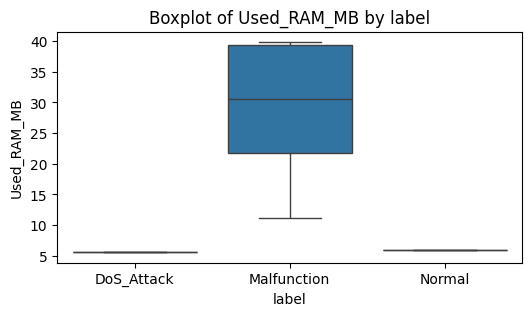

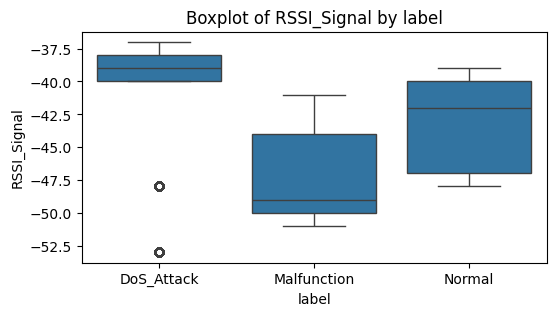

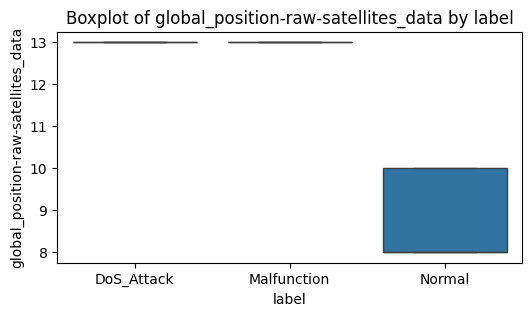

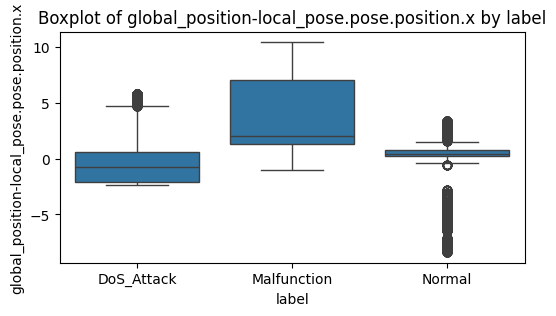

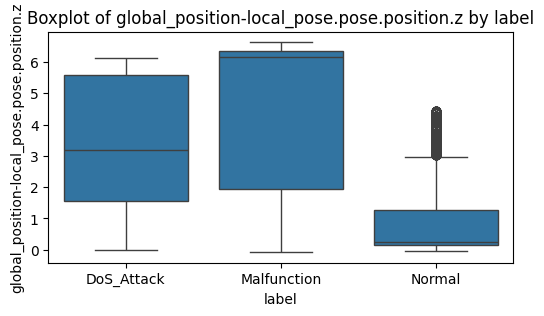

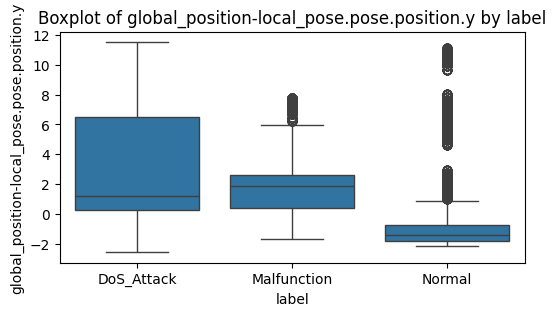

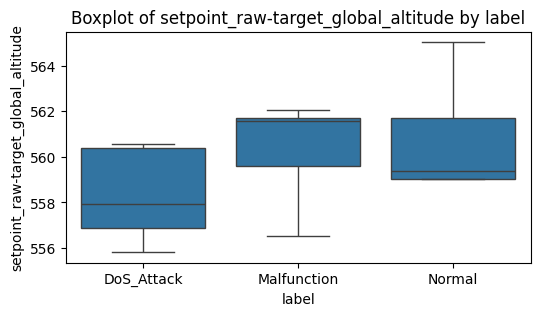

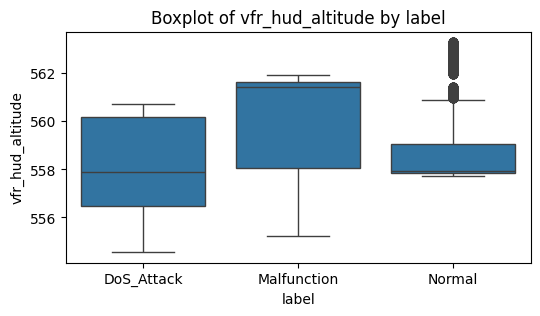

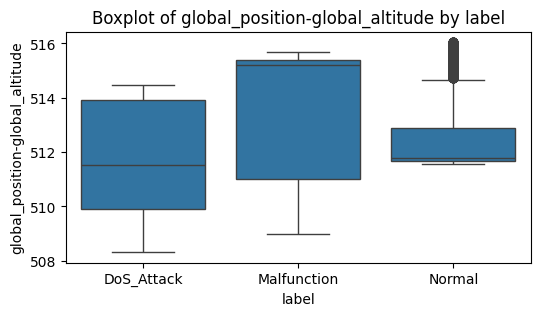

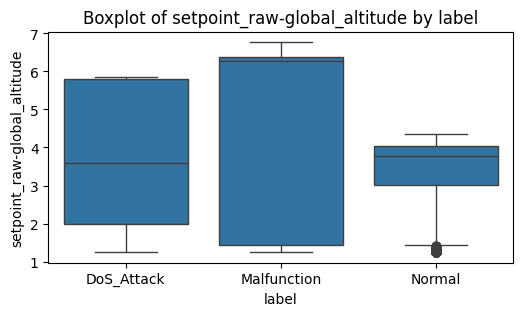

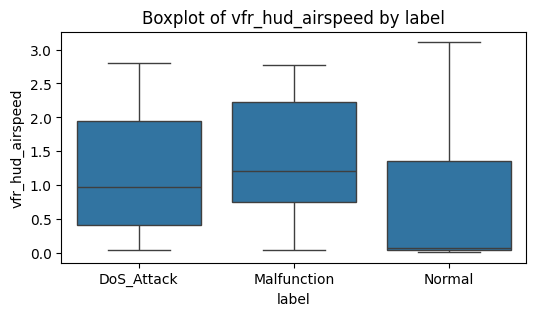

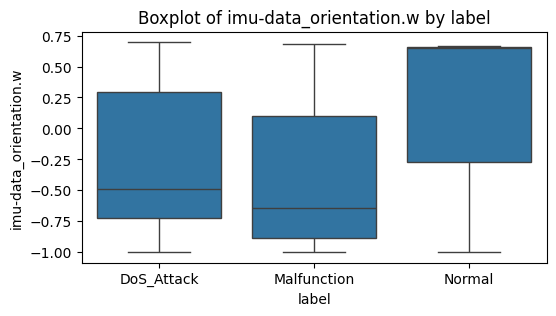

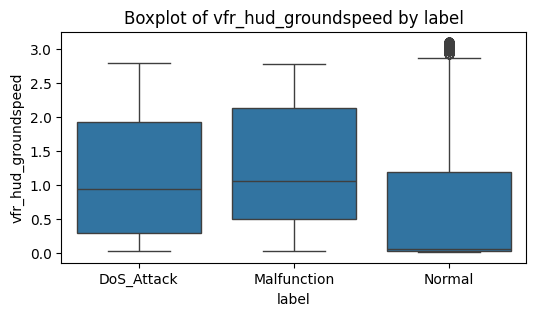

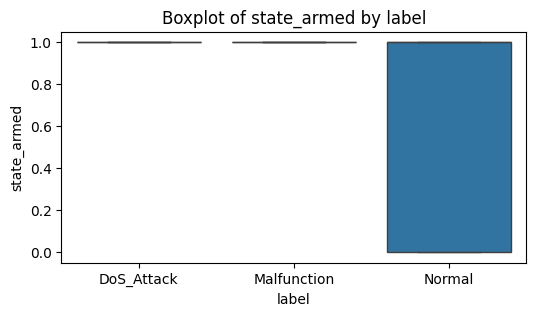

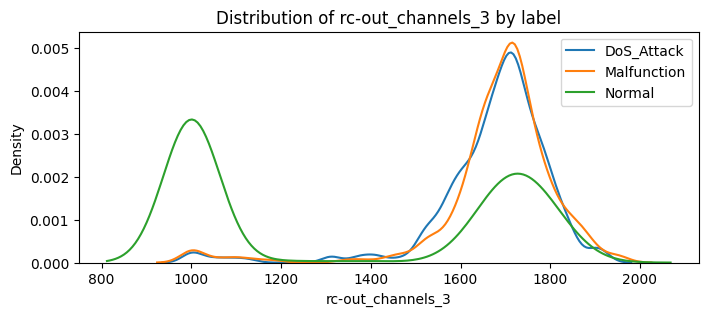

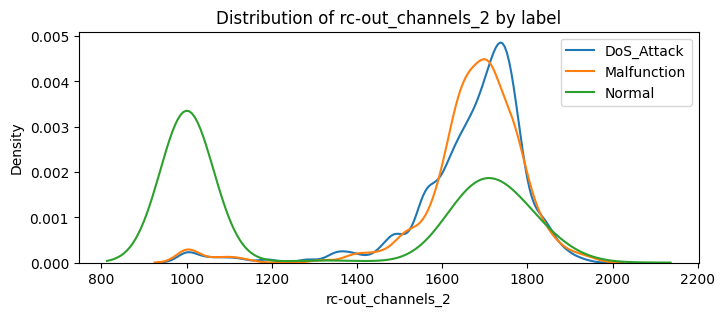

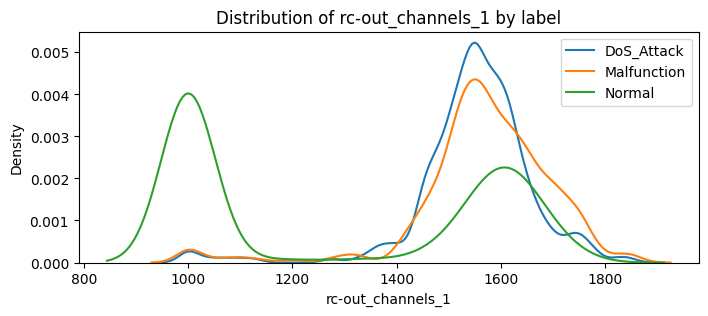

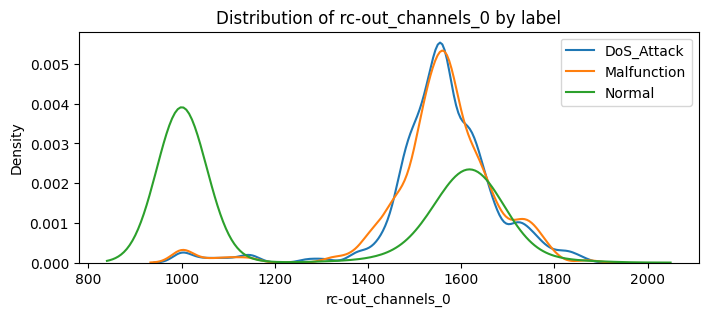

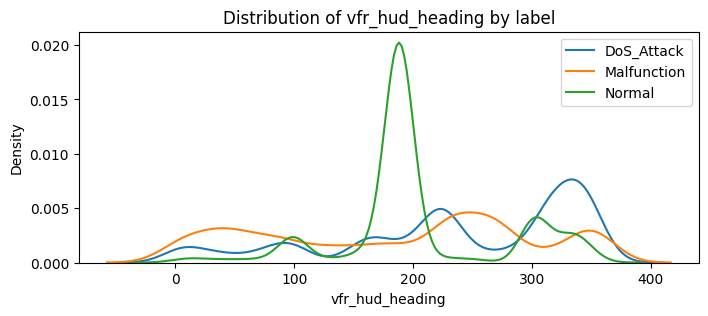

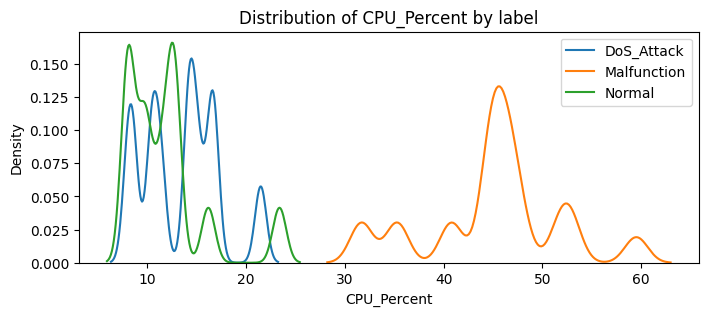

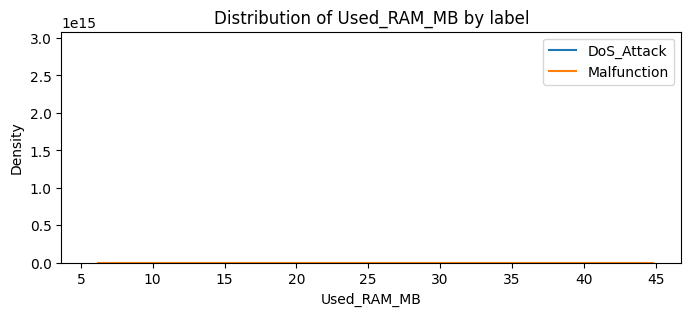

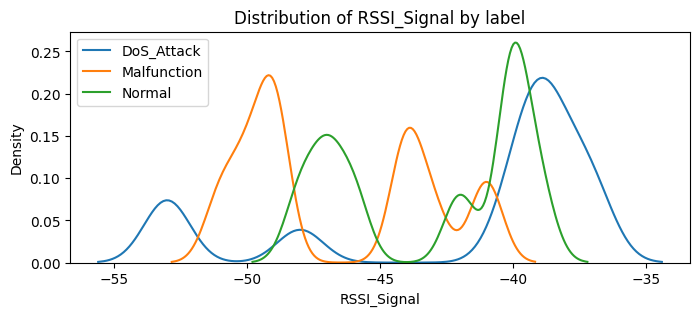

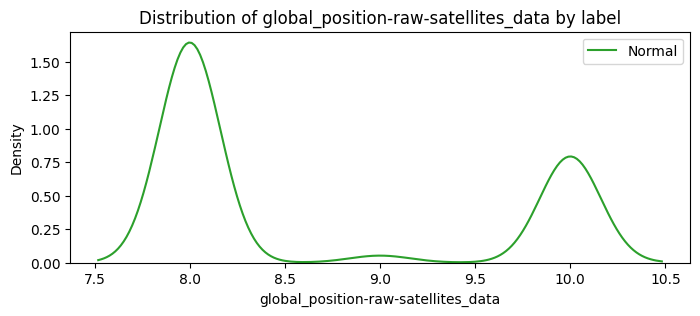

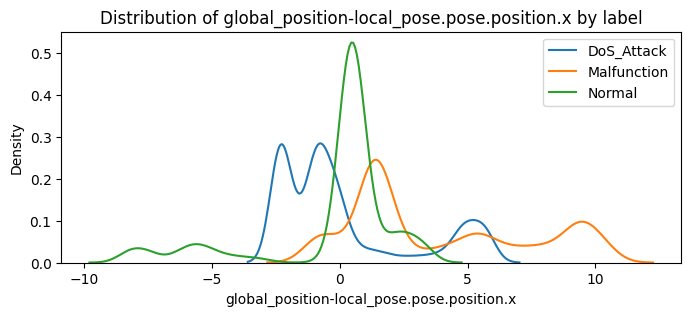

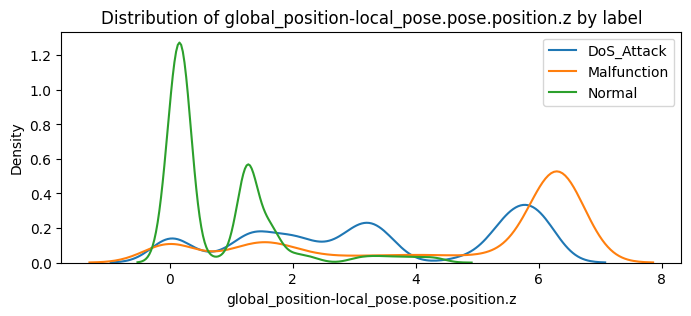

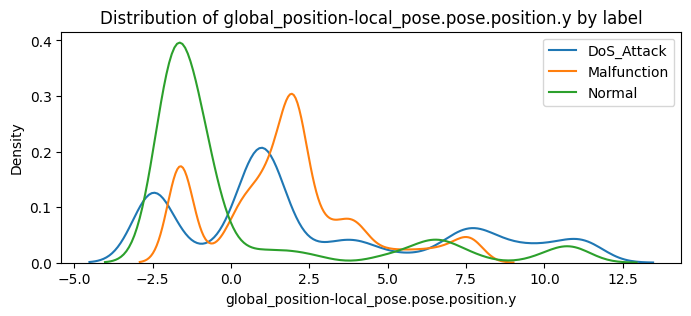

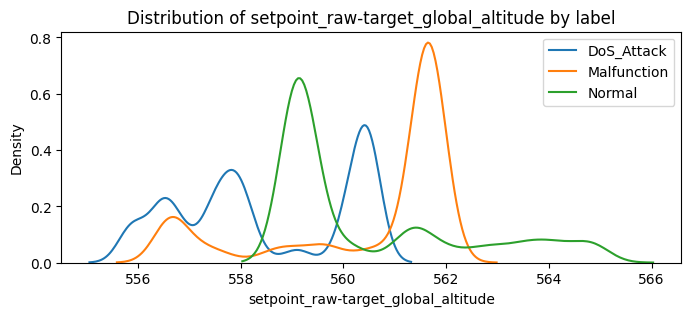

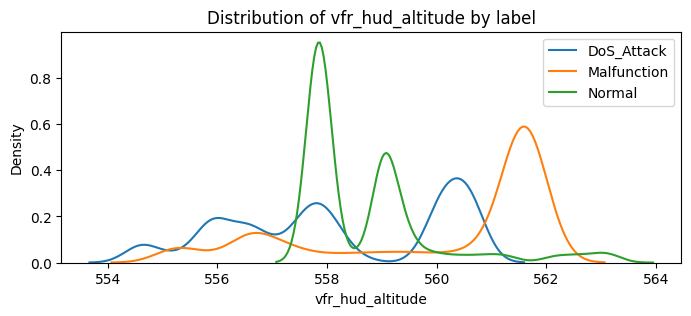

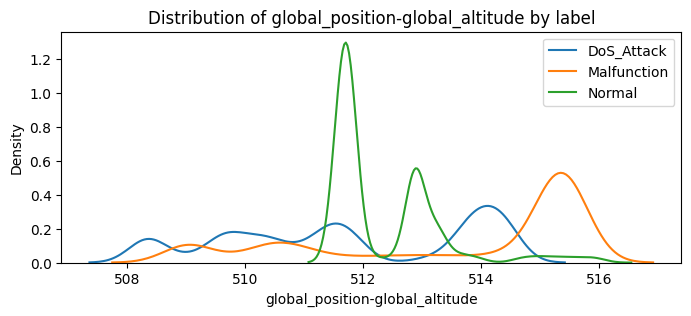

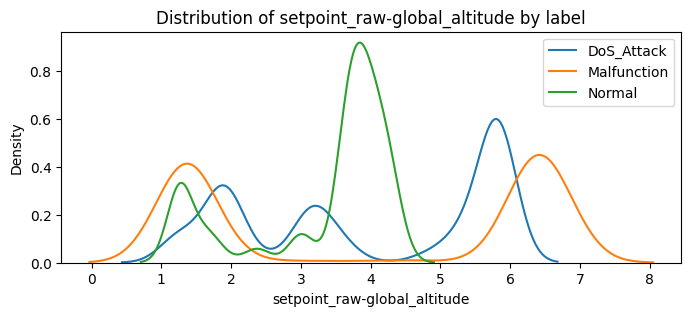

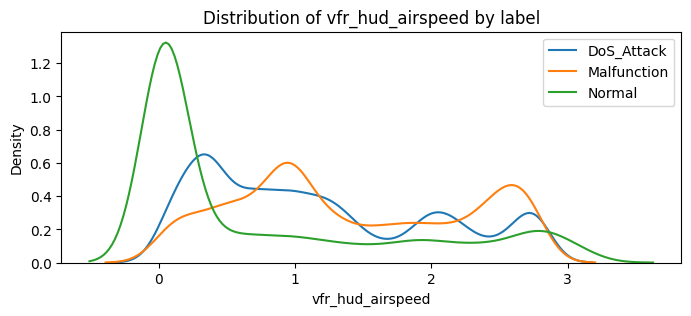

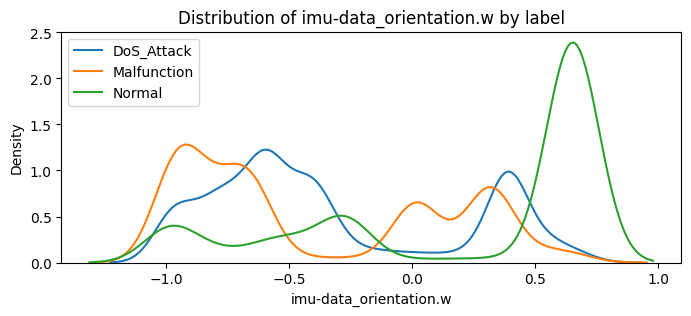

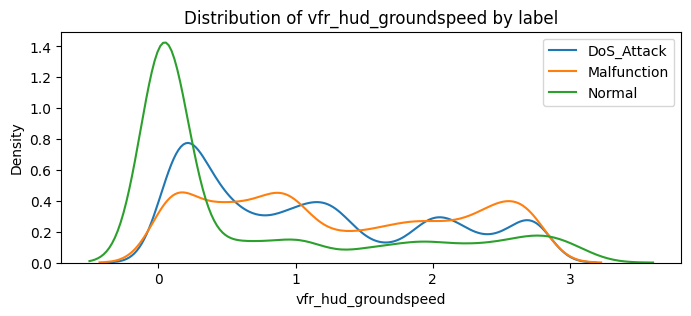

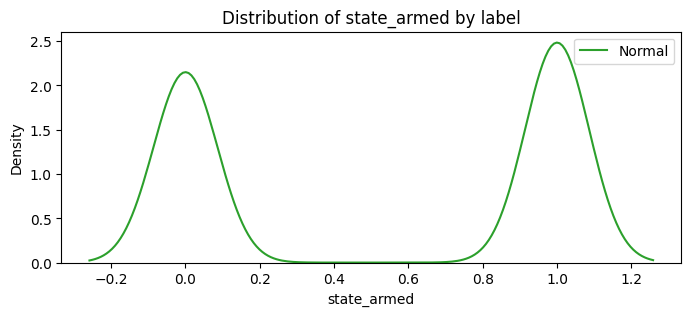

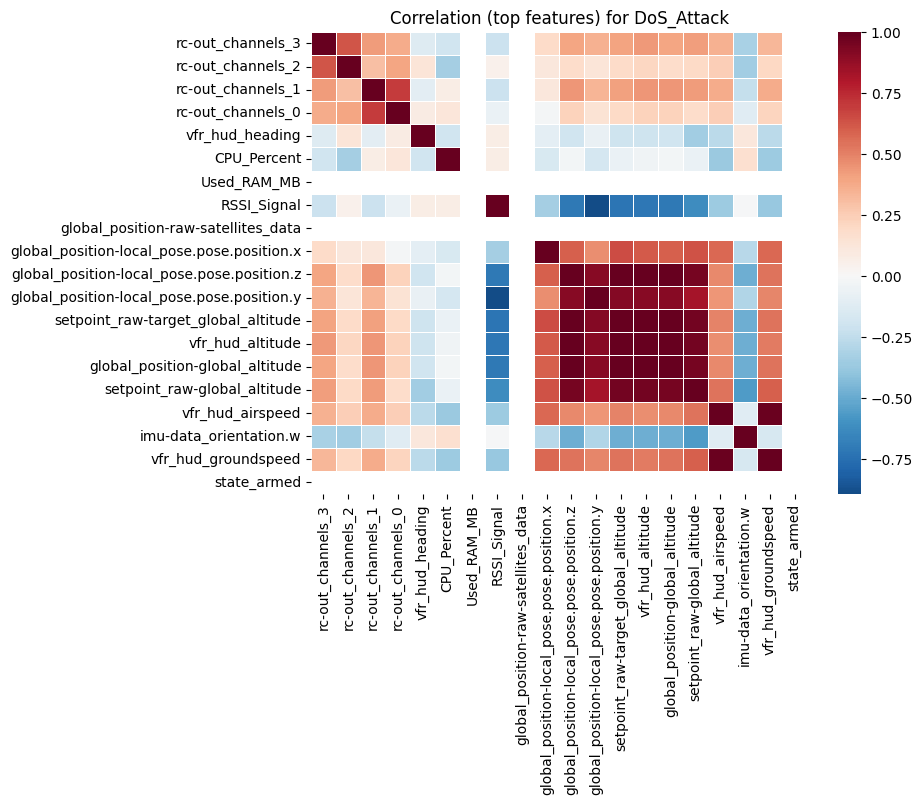

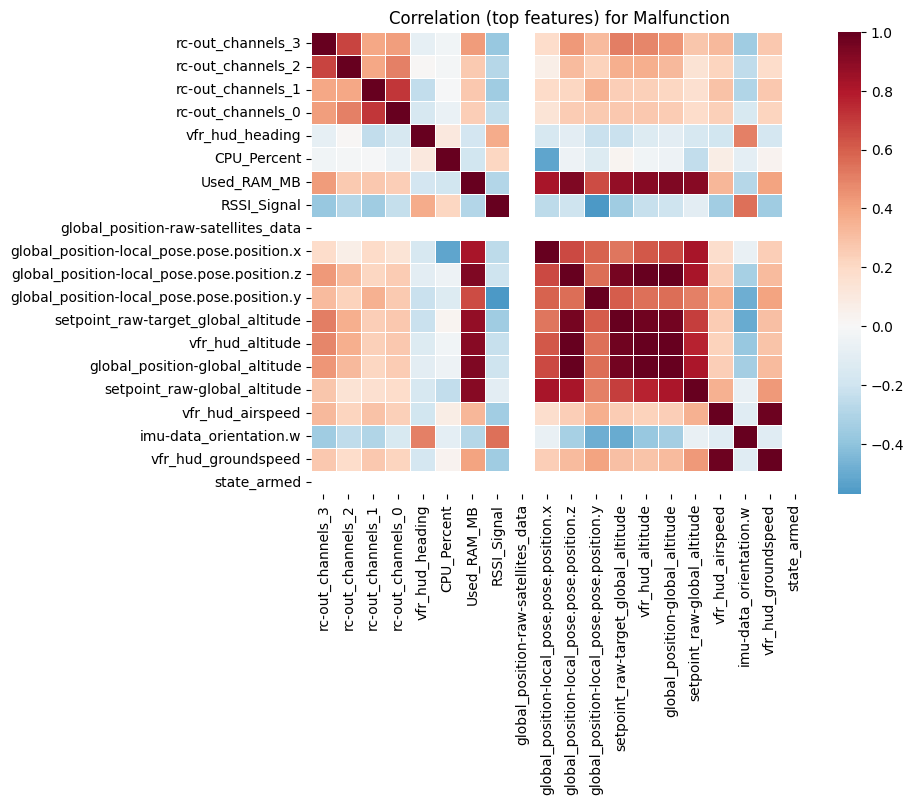

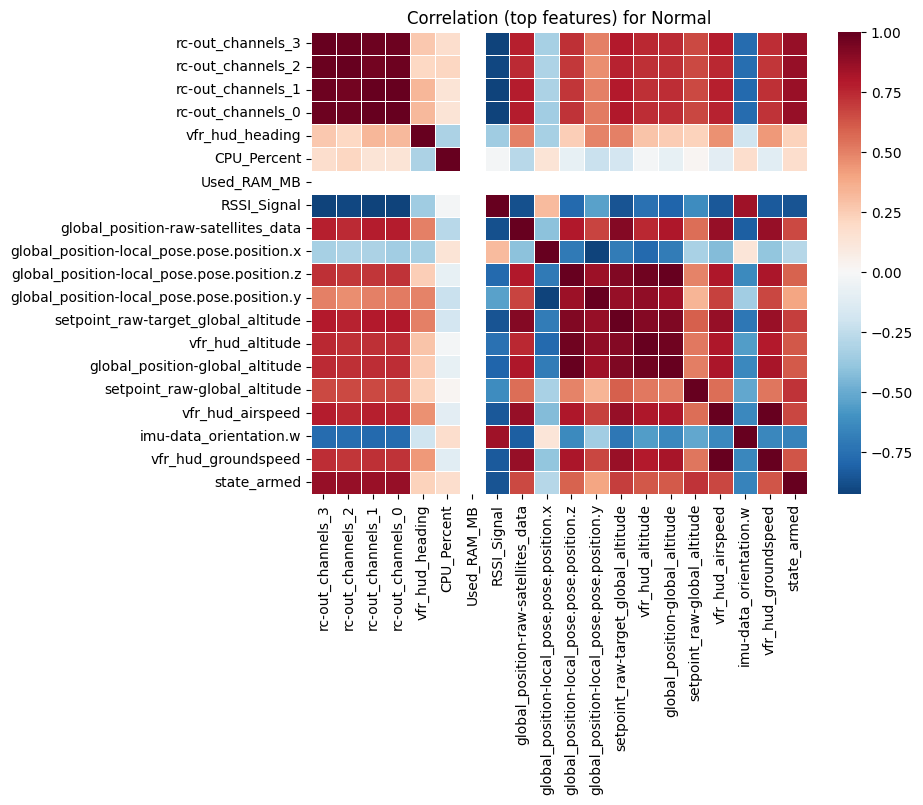


Label-wise EDA complete.


In [ ]:
# EDA by label: group statistics and class-wise plots
print('Counts by label:')
vc = df['label'].value_counts()
print(vc)
# ensure numeric variable list available
numeric = df.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric features count:', len(numeric))
# group means for numeric features
group_mean = df.groupby('label')[numeric].mean() if len(numeric)>0 else pd.DataFrame()
if not group_mean.empty:
    display(group_mean.T.head(20))
    # top features where class means differ the most
    range_per_feature = group_mean.max() - group_mean.min()
    top_diff = range_per_feature.sort_values(ascending=False).head(20).index.tolist()
    print('Top features by mean difference:', top_diff)
    plt.figure(figsize=(8,4))
    range_per_feature[top_diff].plot(kind='bar',colorbar='orange')
    plt.title('Top features by class mean range')
    plt.tight_layout()
    plt.show()
    # Boxplots for top features
    for feat in top_diff[:20]:
        plt.figure(figsize=(6,3))
        sns.boxplot(x='label', y=feat, data=df, order=sorted(df['label'].unique()))
        plt.title(f'Boxplot of {feat} by label')
        plt.show()
    # Class-wise KDE/histograms for top 4 features
    for feat in top_diff[:20]:
        plt.figure(figsize=(8,3))
        for lbl in sorted(df['label'].unique()):
            sns.kdeplot(df.loc[df['label']==lbl, feat].dropna(), label=lbl, fill=False,color='orange')
        plt.title(f'Distribution of {feat} by label')
        plt.legend()
        plt.show()
    # Correlation heatmap per class (top features)
    for lbl in sorted(df['label'].unique()):
        sub = df[df['label']==lbl][top_diff[:20]]
        if sub.shape[0] > 10:
            plt.figure(figsize=(8,6))
            sns.heatmap(sub.corr(), cmap='RdBu_r', center=0, linewidths=.5)
            plt.title(f'Correlation (top features) for {lbl}')
            plt.show()
else:
    print('No numeric features available to compute group statistics.')
print('\nLabel-wise EDA complete.')

# Part 2: Models

In [34]:
drop_cols = [c for c in df.columns if 'Time' in c or 'time' in c.lower() or 'seq' in c.lower() or c=='S.No' or c=='S.No.']

In [35]:
from sklearn.impute import SimpleImputer
# Shared preprocessing: select numeric features, impute, scale, and split
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
# select numeric features (drop identifiers and timestamps)

X = df.drop(columns=[c for c in drop_cols if c in df.columns] + ['label'], errors='ignore')

X = X.select_dtypes(include=[np.number]).copy()
y = df['label'].copy()
print('X shape (numeric only):', X.shape)

le = LabelEncoder()
y_enc = le.fit_transform(y)


X_train_full, X_test, y_train_full, y_test = train_test_split(X, y_enc, test_size=0.15, random_state=42, stratify=y_enc)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.17, random_state=42, stratify=y_train_full)




X shape (numeric only): (37843, 59)


In [12]:

imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_train_imp = imputer.fit_transform(X_train)
X_val_imp = imputer.transform(X_val)
X_test_imp = imputer.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train_imp)
X_val_scaled = scaler.transform(X_val_imp)
X_test_scaled = scaler.transform(X_test_imp)

In [13]:
def eval_and_record(name, model, X_tr, X_te, y_tr, y_te):
    y_pred = model.predict(X_te)
    if y_pred.ndim > 1:
        y_pred = np.argmax(y_pred, axis=1)
    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred, average='macro')
    print(f'{name} Test acc={acc:.4f} f1={f1:.4f}')

In [22]:
from pathlib import Path
Path("saved_models").mkdir(exist_ok=True)

def save_model(name, model):
    with open(f"saved_models/{name}.pkl", "wb") as f:
        pickle.dump(model, f)

def load_model(name):
    with open(f"saved_models/{name}.pkl", "rb") as f:
        return pickle.load(f)

## 2.3 SVM (sklearn)

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

param_grid = {
    'kernel': ['rbf', 'linear'],        
    'C': [0.1, 1, 10],                  
    'gamma': ['scale', 0.01, 0.1]       
}

svc = SVC(probability=False, random_state=42) 

grid = GridSearchCV(svc, param_grid, cv=3, n_jobs=-1)   
grid.fit(X_train_scaled, y_train)

y_pred = grid.predict(X_val_scaled)


print(classification_report(y_val, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

         Dos       1.00      1.00      1.00      2486
      Malfuc       1.00      1.00      1.00      1307
        Norm       1.00      1.00      1.00      1676

    accuracy                           1.00      5469
   macro avg       1.00      1.00      1.00      5469
weighted avg       1.00      1.00      1.00      5469



## 2.4 LSTM 

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import numpy as np
import pandas as pd
from tensorflow.keras import callbacks
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from tensorflow.keras import callbacks
from tensorflow import keras
from tensorflow.keras import layers # pyright: ignore[reportMissingImports]


def LSTM_MODEL(input_shape, n_classes, units=[64,32], dropout=0.2):
    from tensorflow.keras import layers, models # type: ignore
    inp = layers.Input(shape=input_shape)
    x = inp
    for u in units:
        x = layers.LSTM(u, return_sequences=True)(x)
        x = layers.Dropout(dropout)(x)
    x = layers.LSTM(units[-1])(x)
    out = layers.Dense(n_classes, activation='softmax')(x)
    model = models.Model(inp, out)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
results = []
def sequence(X, y, seq_len=10, step=1):
    X = np.asarray(X)
    y = np.asarray(y)
    n = X.shape[0]
    if n < seq_len:
        return np.empty((0, seq_len, X.shape[1])), np.empty((0,), dtype=y.dtype)
    idx = range(0, n - seq_len + 1, step)
    Xs = np.zeros((len(list(idx)), seq_len, X.shape[1]), dtype=X.dtype)
    ys = np.zeros((len(list(idx)),), dtype=y.dtype)
    i = 0
    for s in idx:
        e = s + seq_len
        Xs[i] = X[s:e]
        ys[i] = y[e - 1]
        i += 1
    return Xs, ys

seq_len = 10
step = 1

X_train_seq, y_train_seq = sequence(X_train_scaled, y_train, seq_len, step)
X_val_seq, y_val_seq = sequence(X_val_scaled, y_val, seq_len, step)
X_test_seq, y_test_seq = sequence(X_test_scaled, y_test, seq_len, step)

if X_train_seq.shape[0] == 0:
    raise RuntimeError("Not enough rows")

results = []

def eval_and_record(name, model, X_tr, X_te, y_tr, y_te):
    y_pred = model.predict(X_te)
    if y_pred.ndim > 1:
        y_pred = np.argmax(y_pred, axis=1)
    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred, average='macro')
    results.append({'model': name, 'accuracy': acc, 'f1_macro': f1})
    display(pd.DataFrame(results).sort_values('f1_macro', ascending=False))


In [27]:

def build_model(hp):
    n_layers = hp.Choice('n_layers', [1,2,3])
    units = hp.Choice('units', [32,64,128,256])
    dropout = hp.Choice('dropout', [0.0,0.1,0.2,0.3,0.5])
    lr = hp.Choice('lr', [0.001,0.0001,0.00001])
    opt_name = hp.Choice('optimizer', ['adam','rmsprop','sgd'])
    act = hp.Choice('activation', ['tanh','relu','sigmoid'])
    opt = {
        'adam': keras.optimizers.Adam(lr),
        'rmsprop': keras.optimizers.RMSprop(lr),
        'sgd': keras.optimizers.SGD(lr)
    }[opt_name]

    inp = layers.Input(shape=(seq_len, X_train_seq.shape[2]))
    x = inp
    for i in range(n_layers):
        rs = True if i < n_layers - 1 else False
        x = layers.LSTM(units, activation=act, return_sequences=rs)(x)
        if dropout > 0:
            x = layers.Dropout(dropout)(x)
    out = layers.Dense(len(le.classes_), activation='softmax')(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [28]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=1,
    executions_per_trial=1,
    overwrite=True,
    directory='lstm_tuning',
    project_name='lstm_search'
)

tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    batch_size=tuner.oracle.hyperparameters.Choice('batch_size',[16,32,64]),
    epochs=tuner.oracle.hyperparameters.Choice('epochs',[10,50,60]),
    verbose=2
)

best_hp = tuner.get_best_hyperparameters(1)[0]
lstm = tuner.hypermodel.build(best_hp)

lstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=best_hp.get('epochs'),
    batch_size=best_hp.get('batch_size'),
    verbose=2
)

eval_and_record('LSTM', lstm, X_train_seq, X_test_seq, y_train_seq, y_test_seq)




Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
3                 |3                 |n_layers
32                |32                |units
0                 |0                 |dropout
0.0001            |0.0001            |lr
rmsprop           |rmsprop           |optimizer
tanh              |tanh              |activation
16                |16                |batch_size
10                |10                |epochs

Epoch 1/10


KeyboardInterrupt: 

## 2.6 VAE 

In [17]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def sampling(z_mean, z_log_var):
    eps = tf.random.normal(tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * eps
X_train_scaled = X_train_scaled.astype(np.float32)
X_val_scaled = X_val_scaled.astype(np.float32)
X_test_scaled = X_test_scaled.astype(np.float32)
input_dim = X_train_scaled.shape[1]
latent_dim = 32
enc_layers = [128,64,32]
dec_layers = [32,64,128]
lr = 1e-4
beta = 1.0
epochs = 15
batch_size = 64

encoder_inputs = keras.Input(shape=(input_dim,))
x = encoder_inputs
for u in enc_layers:
    x = layers.Dense(u, activation="relu")(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
z = layers.Lambda(lambda i: sampling(i[0], i[1]))([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z])

decoder_inputs = keras.Input(shape=(latent_dim,))
x = decoder_inputs
for u in dec_layers:
    x = layers.Dense(u, activation="relu")(x)
decoder_outputs = layers.Dense(input_dim)(x)
decoder = keras.Model(decoder_inputs, decoder_outputs)

opt = keras.optimizers.Adam(lr)

train_data = tf.data.Dataset.from_tensor_slices(X_train_scaled).batch(batch_size)
val_data = tf.data.Dataset.from_tensor_slices(X_val_scaled).batch(batch_size)

for epoch in range(epochs):
    for batch in train_data:
        with tf.GradientTape() as tape:
            zm, zv, z = encoder(batch)
            recon = decoder(z)
            rec_loss = tf.reduce_mean(tf.square(batch - recon))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + zv - tf.square(zm) - tf.exp(zv), axis=1))
            total = rec_loss + beta * kl_loss
        grads = tape.gradient(total, encoder.trainable_weights + decoder.trainable_weights)
        opt.apply_gradients(zip(grads, encoder.trainable_weights + decoder.trainable_weights))

z_mean_train, _, _ = encoder.predict(X_train_scaled, verbose=0)
z_mean_test, z_log_var_test, _ = encoder.predict(X_test_scaled, verbose=0)

recon = decoder.predict(z_mean_test, verbose=0)
recon_mse = np.mean((X_test_scaled - recon)**2)
recon_mae = np.mean(np.abs(X_test_scaled - recon))
kl = -0.5 * np.mean(np.sum(1 + z_log_var_test - np.square(z_mean_test) - np.exp(z_log_var_test), axis=1))

kmeans = KMeans(n_clusters=len(np.unique(y_test)), random_state=42)
clusters = kmeans.fit_predict(z_mean_test)
ari = adjusted_rand_score(y_test, clusters)
nmi = normalized_mutual_info_score(y_test, clusters)

print("Reconstruction MSE:", recon_mse)
print("Reconstruction MAE:", recon_mae)
print("KL Divergence:", kl)
print("ARI:", ari)
print("NMI:", nmi)


Reconstruction MSE: 0.8499062
Reconstruction MAE: 0.67835975
KL Divergence: 2.7510845e-07
ARI: -0.00015650189838538897
NMI: 0.0009104708215500755


## Model Comparison

In [ ]:
def evaluate_model(name, model, X_test, y_test, proba=False):
    y_pred = model.predict(X_test)
    if len(y_pred.shape) > 1 and not proba:
        y_pred = np.argmax(y_pred, axis=1)
    if proba:
        try:
            y_score = model.predict_proba(X_test)
        except:
            y_score = None
    else:
        y_score = None
    acc = accuracy_score(y_test, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    auc = roc_auc_score(y_test, y_score, multi_class='ovo') if y_score is not None else np.nan
    return {
        "model": name,
        "accuracy": acc,
        "precision": p,
        "recall": r,
        "f1": f1,
        "auc": auc,
        "pred": y_pred,
        "report": classification_report(y_test, y_pred, output_dict=True),
        "cm": confusion_matrix(y_test, y_pred)
    }


In [31]:
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
import pickle

encoder.save("vae_encoder.h5")
decoder.save("vae_decoder.h5")

z_mean_train, _, _ = encoder.predict(X_train_scaled.astype("float32"), verbose=0)
z_mean_test, _, _ = encoder.predict(X_test_scaled.astype("float32"), verbose=0)

vae_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
vae_clf.fit(z_mean_train, y_train)

lstm=load_model("LSTM")
save_model("VAE_RF", vae_clf)
models = {
    "SVC": grid.best_estimator_,
    "LSTM": lstm,
    "VAE_RF": vae_clf
}

# save_model("SVC", grid.best_estimator_)
# save_model("LSTM", lstm)

model_inputs = {
    "SVC": X_test_scaled,
    "LSTM": X_test_seq,
    "VAE_RF": z_mean_test
}

results = []
eval_data = {}

for name, model in models.items():
    X_input = model_inputs[name]
    proba = hasattr(model, "predict_proba")
    
    if X_input.shape[0] != len(y_test):
        y_test_input = y_test[-X_input.shape[0]:]
    else:
        y_test_input = y_test
    
    res = evaluate_model(name, model, X_input, y_test_input, proba)
    results.append(res)
    eval_data[name] = res

df = pd.DataFrame([{
    "Model": r["model"],
    "Accuracy": r["accuracy"],
    "Precision": r["precision"],
    "Recall": r["recall"],
    "F1": r["f1"],
    "ROC-AUC": r["auc"]
} for r in results])

display(df.sort_values("F1", ascending=False))


ValueError: Input 0 of layer "functional_1" is incompatible with the layer: expected shape=(None, 10, 51), found shape=(32, 10, 59)

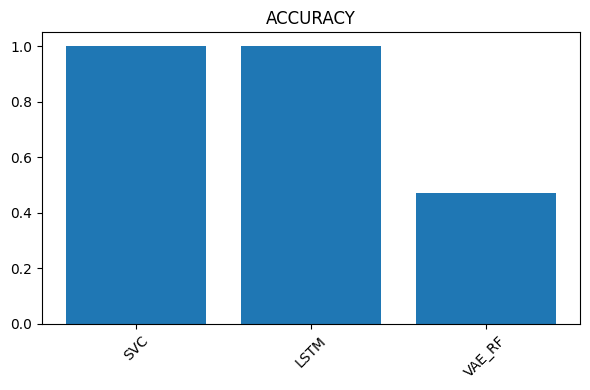

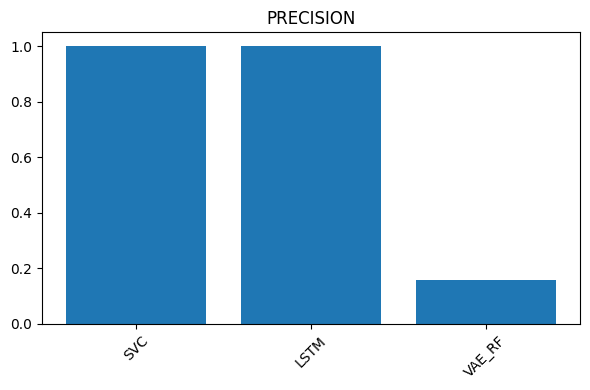

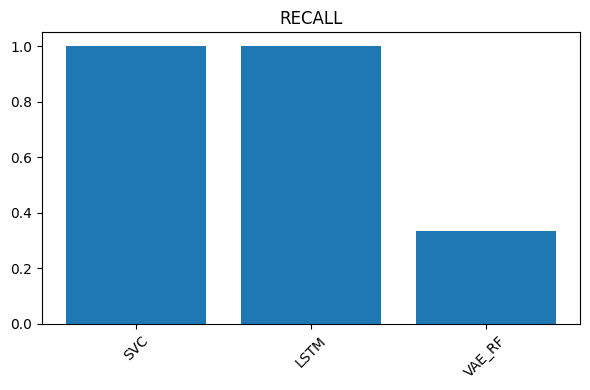

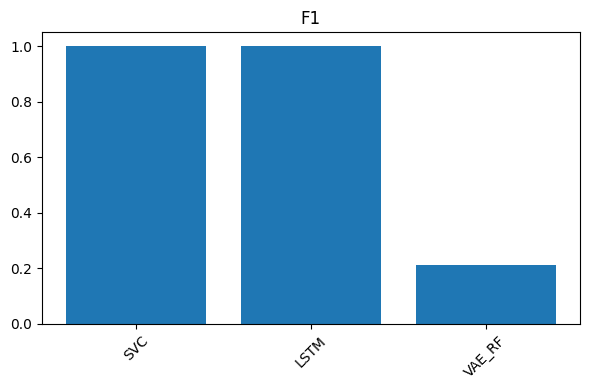

In [82]:
metrics = ["accuracy", "precision", "recall", "f1"]
for m in metrics:
    plt.figure(figsize=(6,4))
    plt.bar(df["Model"], df[m.capitalize()])
    plt.title(m.upper())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


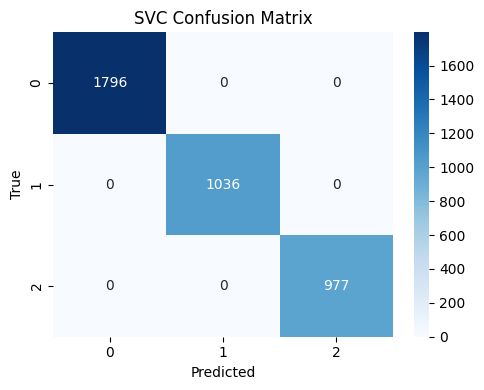

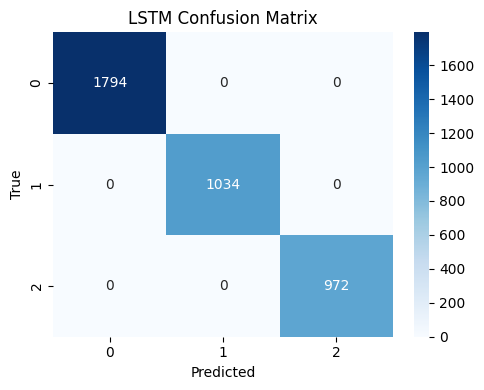

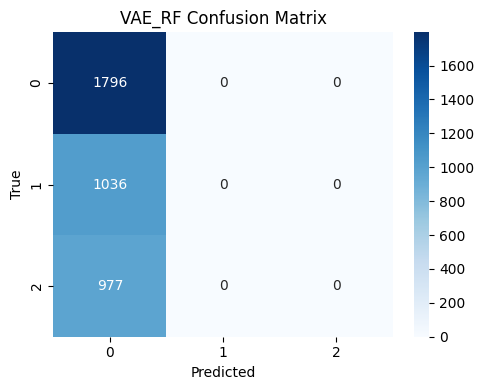

In [83]:
import seaborn as sns

for name, r in eval_data.items():
    plt.figure(figsize=(5,4))
    sns.heatmap(r["cm"], annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


# Part 3: Evaluation helpers and XAI 


In [ ]:
import shap
import numpy as np
import pandas as pd
from tensorflow import keras

lstm=load_model("LSTM")
svm=load_model("SVC")
VAE_RF=load_model("VAE_RF")
FEATURE_NAMES = [i for i in X_test.columns] 
CLASS_NAMES = ['DoS_Attack', 'Malfuc', 'Norm'] 


X_test_df = pd.DataFrame(X_test_scaled, columns=FEATURE_NAMES)


z_mean_test, _, _ = encoder.predict(X_test_scaled, verbose=0)
LATENT_FEATURE_NAMES = [f'latent_{i}' for i in range(latent_dim)] 
z_mean_test_df = pd.DataFrame(z_mean_test, columns=LATENT_FEATURE_NAMES)

100%|██████████| 10/10 [00:34<00:00,  3.48s/it]


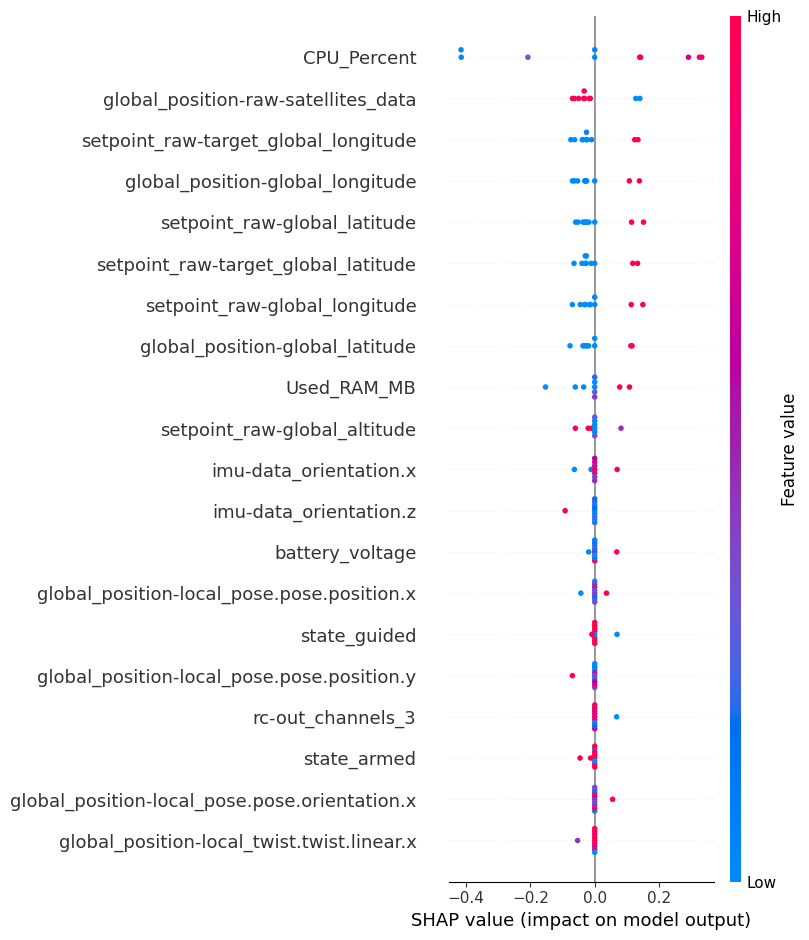

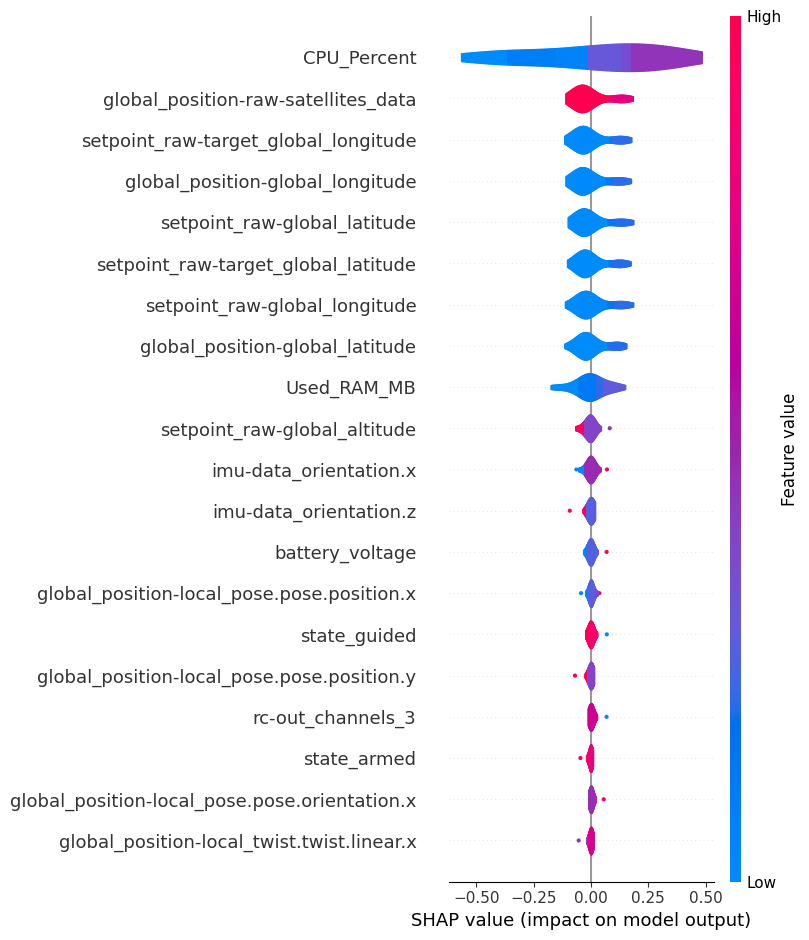

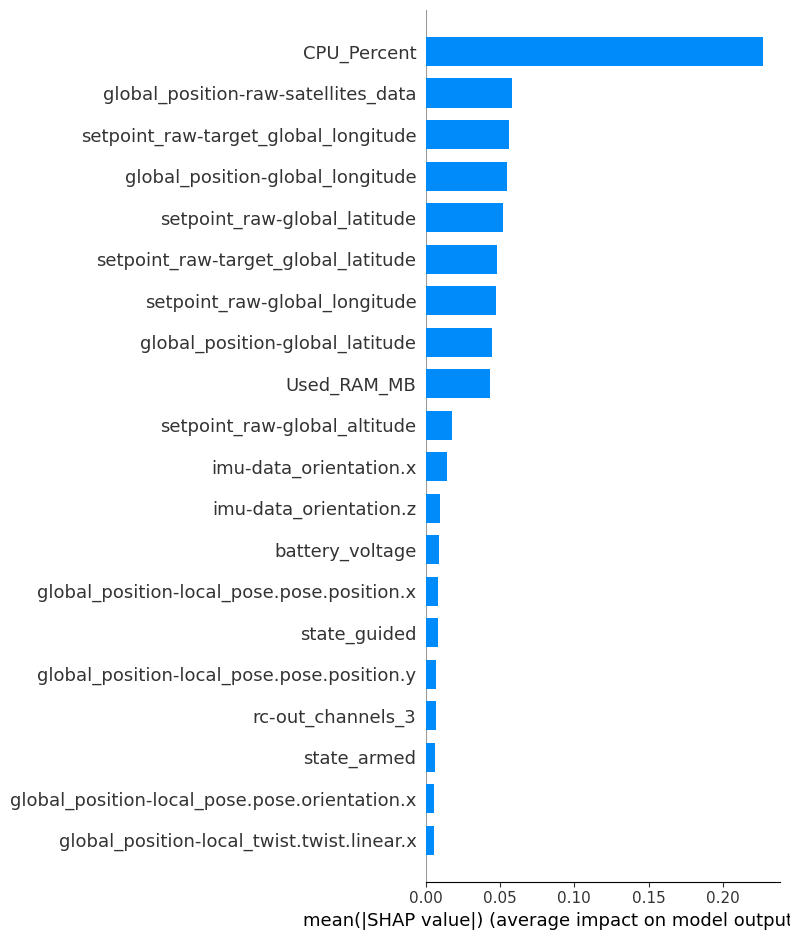

100%|██████████| 10/10 [00:40<00:00,  4.01s/it]


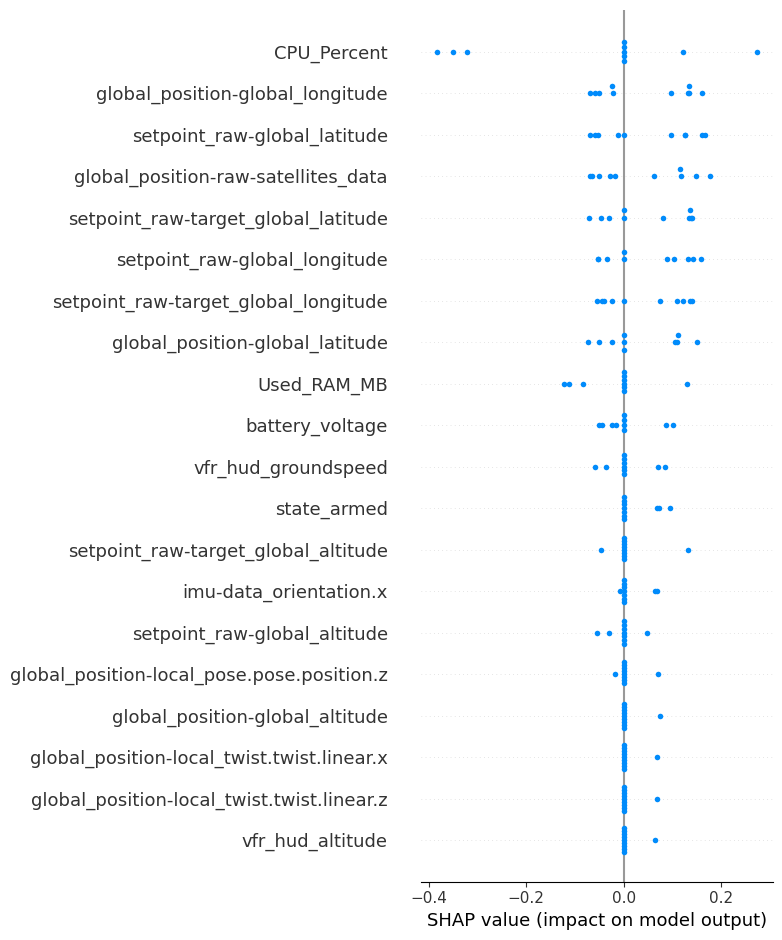

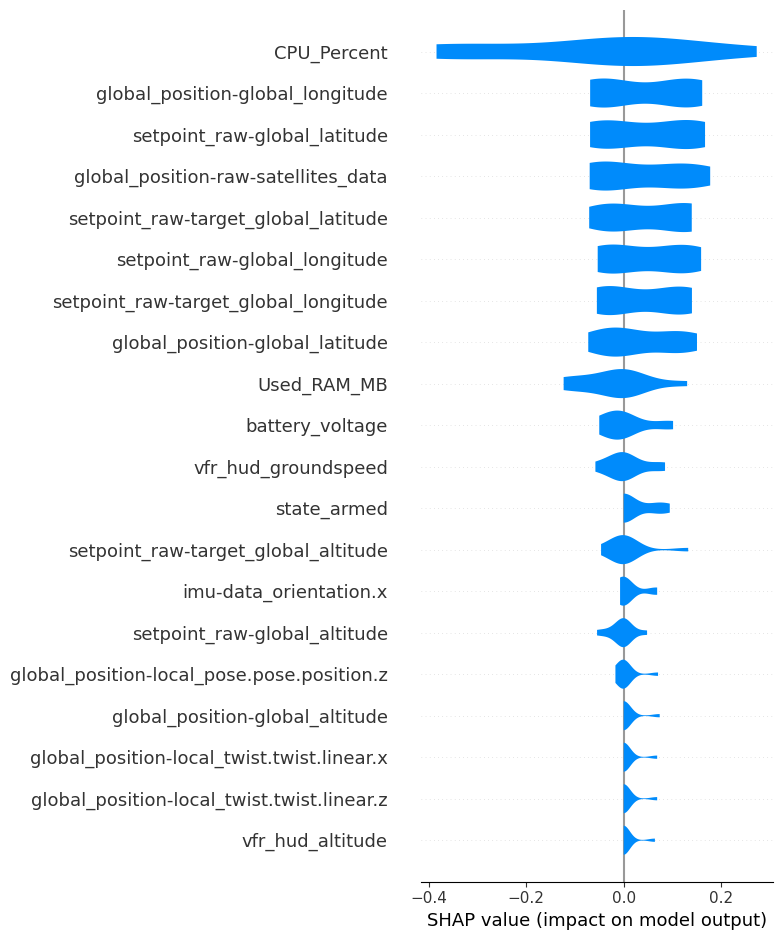

In [53]:
## --- 1. SVC (SVC) XAI ---

X_background = X_test_df.sample(n=100, random_state=42)


svc_explainer = shap.KernelExplainer(svm.predict, X_train_scaled[0:10])

shap_valuestr = svc_explainer.shap_values(X_train_scaled[0:10])
shap.summary_plot(shap_valuestr, X_train_scaled[0:10], feature_names = X_train.columns)
shap.summary_plot(shap_valuestr, X_train_scaled[0:10], feature_names = X_train.columns, plot_type = 'violin')
shap.summary_plot(shap_valuestr, X_train_scaled[0:10], feature_names = X_train.columns, plot_type = 'bar')
shap_valuests = svc_explainer(X_test_scaled[:10])
shap.summary_plot(shap_valuests, X_test.columns)
shap.summary_plot(shap_valuests, X_test.columns, plot_type = 'violin')



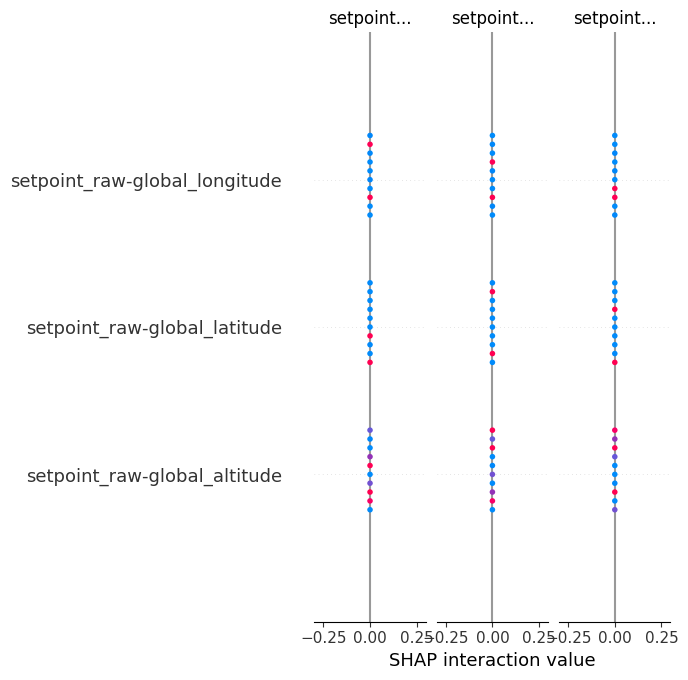

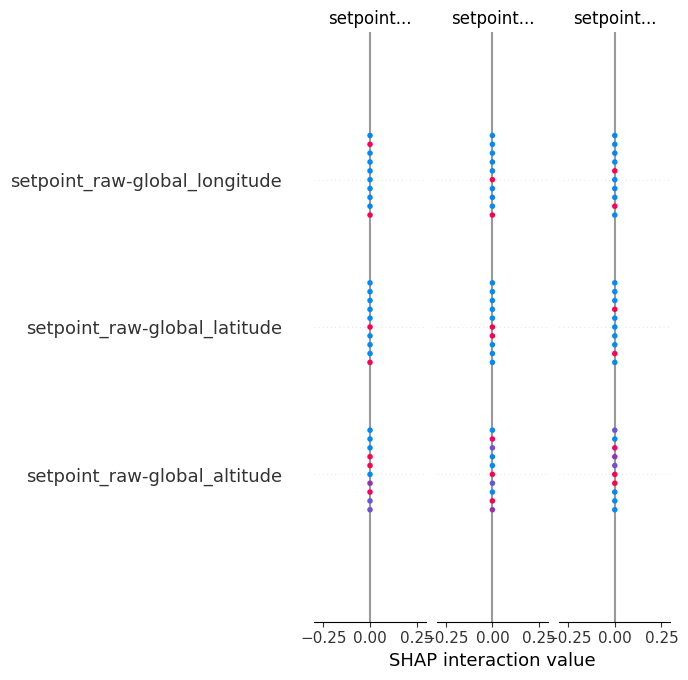